# Create Waveform datasets in bulk

In [ ]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import obspy
from obspy import Stream
from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from obspy import Stream
from datetime import timedelta
from tqdm import tqdm
import csv
import random
from itertools import islice
import time 
import datetime

In [2]:
# === Setup ===
client_iris = Client("IRIS")
client_ncedc = Client("NCEDC")
client_waveform = WaveformClient()


In [3]:
# Constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 150

In [4]:
# Input/output paths
assoc_df = pd.read_csv('/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/arrival_assoc_origin_2010_2015_reloc_cog_ver3.csv', index_col=0)
output_waveform_file = "/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/waveforms_HH_BH_on_the_fly_bulk_test.h5"
output_metadata_file = "/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/metadata_HH_BH_on_the_fly_bulk_test.csv"
error_log_file = "/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/save_errors_on_the_fly_bulk_test.csv"

In [5]:
# Preprocess dataframe
assoc_df[['network', 'station']] = assoc_df['sta'].str.split('.', expand=True)
assoc_df['event_id'] = 'ev' + assoc_df['otime'].astype(str).str.replace('.', '_')
# group_iter = assoc_df.groupby(['event_id', 'network', 'station'])


In [6]:
def pad_waveform_stream(stream: Stream, expected_len: int) -> np.ndarray:
    """
    Converts an ObsPy stream into a (3, expected_len) numpy array, 
    consistently ordered as [Z, E, N], padding missing components with zeros.

    Parameters:
    - stream: ObsPy Stream containing cleaned traces (padded to expected_len)
    - expected_len: Target length of each waveform trace

    Returns:
    - data_array: np.ndarray of shape (3, expected_len)
    """
    # Fixed component order: Z → 0, E → 1, N → 2
    comp_to_index = {"Z": 0, "E": 1, "N": 2}
    data_list = [np.zeros(expected_len) for _ in range(3)]  # Default to zeros

    for tr in stream:
        chan_suffix = tr.stats.channel[-1]
#         print('chan_suffix',chan_suffix)
        if chan_suffix in comp_to_index:
            idx = comp_to_index[chan_suffix]
#             print('idx',idx)
            data_list[idx] = tr.data  

    return np.vstack(data_list)  # Shape: (3, expected_len)


## Gather station information

In [7]:
unique_ns = assoc_df.sta.unique()

In [9]:
len(unique_ns)

440

In [10]:
starttime_bulk = obspy.UTCDateTime("2010-01-01T00:00:00")
endtime_bulk = obspy.UTCDateTime("2015-12-31T23:59:59")

In [11]:
# compose 
bulk =[]
for u_ns in unique_ns:
    n,s = u_ns.split('.')

    for bi in ['EH?', 'BH?', 'HH?']:
        line = (n, s, '*', bi, starttime_bulk, endtime_bulk)
        bulk.append(line)

len(bulk)

1320

In [12]:
# Estimate: Each channel metadata entry ~2-4 KB (depends on response info, etc.)
approx_bytes_per_channel = 3000  # 3 KB per channel (very rough)

# Count how many bulk requests you will make
num_bulk_lines = len(bulk)

# Assume each bulk line returns ~3 channels (Z, N, E) for each station
channels_per_bulk = 3

# Total estimated channels
total_channels = num_bulk_lines * channels_per_bulk

# Estimated total memory in bytes
estimated_bytes = total_channels * approx_bytes_per_channel

# Convert to MB
estimated_mb = estimated_bytes / (1024 * 1024)
print(f"Estimated Inventory memory usage: {estimated_mb:.2f} MB")

Estimated Inventory memory usage: 11.33 MB


## Download the station inventory

In [13]:
inv = client_iris.get_stations_bulk(bulk, level='channel')
time.sleep(0.2)

In [14]:
inv

Inventory created at 2025-08-03T03:47:30.395500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (14):
			7A, 7D, BK, C8, CN, NC, NV, OO, PB, TA, UO, UW, X9, Z5
		Stations (440):
			7A.W01 (WHOI OBS ID S85)
			7A.W02 (WHOI OBS ID S83)
			7A.W03 (WHOI OBS ID S86)
			7A.W04 (WHOI OBS ID S89)
			7A.W06 (WHOI OBS ID S80)
			7A.W07 (WHOI OBS ID S82)
			7A.W08 (WHOI OBS ID S81)
			7A.W09 (WHOI OBS ID S84)
			7A.W10 (WHOI OBS ID S88)
			7D.FC03D (LDEO OBS TRAWL-RESISTANT)
			7D.FN01C (LDEO OBS TRAWL-RESISTANT)
			7D.FN02C (LDEO OBS TRAWL-RESISTANT)
			7D.FN03C (LDEO OBS TRAWL-RESISTANT)
			7D.FN04C (LDEO OBS TRAWL-RESISTANT)
			7D.FN05C (LDEO OBS TRAWL-RESISTANT)
			7D.FN07A (LDEO Trawl-Resistant OBS Site FN07A)
			7D.FN07C (LDEO OBS TRAWL-RESISTANT)
			7D.FN08A (LDEO Trawl-Resistant OBS Site FN08A)
			7D.FN08C (LDEO OBS TRAWL-RESISTANT)
			7D.FN09C (LDEO OBS TRAWL-RESISTANT)
			7D.FN10C (LDEO OBS TRAWL-RES

Inventory created at 2025-08-01T08:39:35.812400Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			UW
		Stations (1):
			UW.GNW (Green Mountain, WA, USA)
		Channels (9):
			UW.GNW..BHZ (3x), UW.GNW..BHN (3x), UW.GNW..BHE (3x)

In [15]:
import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects in bytes."""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)

    if isinstance(obj, dict):
        size += sum(get_size(k, seen) + get_size(v, seen) for k, v in obj.items())
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum(get_size(i, seen) for i in obj)

    return size

print(f"Inventory object size: {get_size(inv)/1024:.2f} KB")

Inventory object size: 6590.90 KB


## Gather waveform information

If the station picked pnly P or both P and S for an event, the trace start time is the pick time of P minus 50 s and the end time is the pick time of P plus 100 s.  

If the station picked pnly S for an event, the trace start time is the pick time of S minus 50 s and the end time is the pick time of S plus 100 s.


In [16]:
unique_n_s_otime = assoc_df.drop_duplicates(['event_id', 'network', 'station'],keep='first').reset_index(drop=True)
unique_n_s_otime

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,network,station,event_id
0,UW.PCMD,1.262305e+09,0,P,0.680,0,P,0.049,46.888962,-122.301483,...,7,2,5,1.081,5.0,235.831208,genie,UW,PCMD,ev1262304917_262282
1,UW.RVW,1.262305e+09,1,P,0.680,0,P,1.264,46.149750,-122.742996,...,7,2,5,1.081,5.0,235.831208,genie,UW,RVW,ev1262304917_262282
2,UW.GNW,1.262305e+09,3,S,0.680,0,S,2.402,47.564130,-122.824980,...,7,2,5,1.081,5.0,235.831208,genie,UW,GNW,ev1262304917_262282
3,PB.B013,1.262305e+09,4,S,0.680,0,S,-0.651,47.813000,-122.910797,...,7,2,5,1.081,5.0,235.831208,genie,PB,B013,ev1262304917_262282
4,PB.B943,1.262305e+09,5,S,0.680,0,S,-0.511,47.813202,-122.911301,...,7,2,5,1.081,5.0,235.831208,genie,PB,B943,ev1262304917_262282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690483,7D.J11D,1.435102e+09,1004326,P,0.694,63886,P,-0.336,43.541599,-126.368599,...,9,4,5,0.447,5.0,247.683119,genie,7D,J11D,ev1435101498_841147
690484,7D.J19D,1.435102e+09,1004327,P,0.694,63886,P,-0.419,44.179001,-126.271202,...,9,4,5,0.447,5.0,247.683119,genie,7D,J19D,ev1435101498_841147
690485,7D.J10D,1.435102e+09,1004328,P,0.694,63886,P,-0.505,43.348499,-125.545097,...,9,4,5,0.447,5.0,247.683119,genie,7D,J10D,ev1435101498_841147
690486,7D.J27D,1.435102e+09,1004329,P,0.694,63886,P,0.915,44.848900,-126.308296,...,9,4,5,0.447,5.0,247.683119,genie,7D,J27D,ev1435101498_841147


In [ ]:
unique_n_s_picktime.iloc[0]['otime']

NameError: name 'unique_n_s_picktime' is not defined

In [ ]:

unique_n_s_picktime.iloc[0]['otime']

NameError: name 'unique_n_s_picktime' is not defined

In [ ]:
bytes_per_trace = 6e4
num_compoenents = 3 
num_stas = len(unique_n_s_otime)

total_size = bytes_per_trace * num_compoenents * num_stas
total_size// 1e6  # Convert to MB

124287.0

In [ ]:
for i in range(0, 10):
    print(i)
    time.sleep(1)

0
1
2
3
4
5
6
7
8
9


In [17]:
def append_bulk_lists_chunks(bulk_waveforms, n, s, bi, trace_start, trace_end, day_end, next_day_start):
    """
    Append waveform requests to the bulk list based on the availability of HH? and BH? channels.
    """
    if day_end > trace_end:
        # If the trace end is within the same day, we can use HH?
        bulk_waveforms.append((n, s, '*', bi, trace_start, trace_end))
    else:
        # If the trace end goes beyond the day, we need to adjust
        bulk_waveforms.append((n, s, '*', bi, trace_start, day_end))
        bulk_waveforms.append((n, s, '*', bi, next_day_start, trace_end))
    return bulk_waveforms

In [18]:
def append_bulk_lists(bulk_waveforms, n, s, bi, trace_start, trace_end):
    """
    Append waveform requests to the bulk list based on the availability of HH? and BH? channels.
    """
    bulk_waveforms.append((n, s, '*', bi, trace_start, trace_end))

    return bulk_waveforms

In [19]:
# compose 
batches_bulk_waveforms_chunks =[]
batches_bulk_waveforms_chunks_ncedc =[]

batches_bulk_waveforms = []
num_batches = 10
len_batches = len(unique_n_s_otime) // num_batches

count_EH_pairs = 0

# Constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 150

for i in tqdm(range(0, num_batches+1)):
    bulk_waveforms_chunks = []
    bulk_waveforms_chunks_ncedc = []
    bulk_waveforms = []
    time.sleep(0.2)

    for index, u_ns in islice(unique_n_s_otime.iterrows(), i*len_batches, (i + 1) * len_batches):
        n,s = u_ns['network'], u_ns['station']

        first_arrival = u_ns['otime']
        pick_time = u_ns['pick_time']
        trace_start = obspy.UTCDateTime(first_arrival - pre_arrival_time)
        trace_end = trace_start + window_length

        day_end = obspy.UTCDateTime(trace_start.date + timedelta(days=1))-1e-6
        next_day_start = obspy.UTCDateTime(trace_start.date + timedelta(days=1))

        # print(trace_start, trace_end)

        sta = inv.select(network=n, station=s, time=pick_time)

        has_Z = bool(sta.select(channel='??Z'))
        has_HH = bool(sta.select(channel='HH?'))
        has_BH = bool(sta.select(channel='BH?'))

        if not has_Z or not (has_HH or has_BH):
            count_EH_pairs += 1
            # print("count_EH_pairs", count_EH_pairs)
            continue
        
        if has_HH:
            if n in ['NC', 'BK']:
                bulk_waveforms_chunks_ncedc = append_bulk_lists_chunks(bulk_waveforms_chunks_ncedc, n, s, 'HH?', trace_start, trace_end, day_end, next_day_start)
            else:
                bulk_waveforms_chunks = append_bulk_lists_chunks(bulk_waveforms_chunks, n, s, 'HH?', trace_start, trace_end, day_end, next_day_start)
            
            bulk_waveforms = append_bulk_lists(bulk_waveforms, n, s, 'HH?', trace_start, trace_end)

        else:
            if n in ['NC', 'BK']:
                bulk_waveforms_chunks_ncedc = append_bulk_lists_chunks(bulk_waveforms_chunks_ncedc, n, s, 'BH?', trace_start, trace_end, day_end, next_day_start)
            else:
                bulk_waveforms_chunks = append_bulk_lists_chunks(bulk_waveforms_chunks, n, s, 'BH?', trace_start, trace_end, day_end, next_day_start)
            
            bulk_waveforms = append_bulk_lists(bulk_waveforms, n, s, 'BH?', trace_start, trace_end)

    batches_bulk_waveforms_chunks.append(bulk_waveforms_chunks)
    batches_bulk_waveforms_chunks_ncedc.append(bulk_waveforms_chunks_ncedc)
    batches_bulk_waveforms.append(bulk_waveforms)


100%|██████████| 11/11 [06:40<00:00, 36.37s/it]


In [20]:
num_waveforms = 0
for i in range(len(batches_bulk_waveforms_chunks)):
    len_batches = len(batches_bulk_waveforms_chunks[i])
    num_waveforms += len_batches
    print(f"Batch {i+1} has {len_batches} waveform requests.")

print(f"Total number of waveforms from HH and BH stations: {num_waveforms}")

Batch 1 has 4167 waveform requests.
Batch 2 has 6158 waveform requests.
Batch 3 has 16880 waveform requests.
Batch 4 has 25065 waveform requests.
Batch 5 has 43845 waveform requests.
Batch 6 has 38957 waveform requests.
Batch 7 has 35708 waveform requests.
Batch 8 has 38259 waveform requests.
Batch 9 has 48868 waveform requests.
Batch 10 has 48765 waveform requests.
Batch 11 has 8 waveform requests.
Total number of waveforms from HH and BH stations: 306680


In [21]:
num_waveforms = 0
for i in range(len(batches_bulk_waveforms_chunks_ncedc)):
    len_batches = len(batches_bulk_waveforms_chunks_ncedc[i])
    num_waveforms += len_batches
    print(f"Batch {i+1} has {len_batches} waveform requests.")

print(f"Total number of waveforms from HH and BH stations: {num_waveforms}")

Batch 1 has 0 waveform requests.
Batch 2 has 3639 waveform requests.
Batch 3 has 7750 waveform requests.
Batch 4 has 9549 waveform requests.
Batch 5 has 6676 waveform requests.
Batch 6 has 14603 waveform requests.
Batch 7 has 14481 waveform requests.
Batch 8 has 11625 waveform requests.
Batch 9 has 7412 waveform requests.
Batch 10 has 7138 waveform requests.
Batch 11 has 0 waveform requests.
Total number of waveforms from HH and BH stations: 82873


In [22]:
num_waveforms = 0
for i in range(len(batches_bulk_waveforms)):
    len_batches = len(batches_bulk_waveforms[i])
    num_waveforms += len_batches
    print(f"Batch {i+1} has {len_batches} waveform requests.")

print(f"Total number of waveforms from HH and BH stations: {num_waveforms}")

Batch 1 has 4154 waveform requests.
Batch 2 has 9786 waveform requests.
Batch 3 has 24601 waveform requests.
Batch 4 has 34557 waveform requests.
Batch 5 has 50430 waveform requests.
Batch 6 has 53499 waveform requests.
Batch 7 has 50130 waveform requests.
Batch 8 has 49835 waveform requests.
Batch 9 has 56195 waveform requests.
Batch 10 has 55804 waveform requests.
Batch 11 has 8 waveform requests.
Total number of waveforms from HH and BH stations: 388999


In [23]:
count_EH_pairs

301489

In [24]:
num_waveforms + count_EH_pairs == len(unique_n_s_otime)

True

In [ ]:
# batch = batches_bulk_waveforms_chunks[0]

# st = client_waveform.get_waveforms_bulk(batch)
# time.sleep(0.2)
# # st_sta = st.select(network='NC', station='BKS', location='*', channel='HHZ',star)

In [ ]:
n_s_time = batches_bulk_waveforms[0][100]
n_s_time

('CN',
 'WSLR',
 '*',
 'BH?',
 2010-01-10T04:33:10.041394Z,
 2010-01-10T04:35:40.041394Z)

In [ ]:
n_s_time[0]

'UW'

In [ ]:
st

5921 Trace(s) in Stream:

UW.GNW..BHE | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.272000Z | 50.0 Hz, 7501 samples
...
(5919 other traces)
...
UW.DOSE..BHZ | 2010-11-13T08:39:12.105000Z - 2010-11-13T08:41:42.105000Z | 40.0 Hz, 6001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [ ]:
 n_s_time[4], n_s_time[5]

(2010-01-01T00:14:27.262282Z, 2010-01-01T00:16:57.262282Z)

In [ ]:
inv_n_s_time.s

AttributeError: 'Inventory' object has no attribute 'starttime'

In [ ]:
n_s_time[1]

'GNW'

In [ ]:
n_s_time[4]

2010-01-01T00:14:27.262282Z

In [ ]:
n_s_time[5]

2010-01-01T00:16:57.262282Z

In [ ]:
inv_n_s_time = inv.select(network = n_s_time[0], station = n_s_time[1], location=n_s_time[2], channel = '*',
                           starttime = n_s_time[4], endtime = n_s_time[5])
st_n_s = st.select(inventory=inv_n_s_time)
st_n_s

912 Trace(s) in Stream:

CN.WSLR..BHE | 2010-01-01T19:27:58.550000Z - 2010-01-01T19:30:28.550000Z | 40.0 Hz, 6001 samples
...
(910 other traces)
...
CN.WSLR..BHZ | 2010-11-12T17:35:35.650000Z - 2010-11-12T17:38:05.650000Z | 40.0 Hz, 6001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [ ]:
for tr in st_n_s[0:10]:
    print(tr.id, tr.stats.starttime, tr.stats.endtime)

UW.GNW..BHE 2010-01-01T00:14:43.262000Z 2010-01-01T00:14:43.262000Z
UW.GNW..BHN 2010-01-01T00:14:43.262000Z 2010-01-01T00:14:43.262000Z
UW.GNW..BHZ 2010-01-01T00:14:43.262000Z 2010-01-01T00:14:43.262000Z
UW.GNW..BHE 2010-01-01T00:15:59.372000Z 2010-01-01T00:18:29.372000Z
UW.GNW..BHN 2010-01-01T00:15:59.372000Z 2010-01-01T00:18:29.372000Z
UW.GNW..BHZ 2010-01-01T00:15:59.372000Z 2010-01-01T00:18:29.372000Z
UW.GNW..BHE 2010-01-01T07:17:13.692000Z 2010-01-01T07:19:43.692000Z
UW.GNW..BHN 2010-01-01T07:17:13.692000Z 2010-01-01T07:19:43.692000Z
UW.GNW..BHZ 2010-01-01T07:17:13.692000Z 2010-01-01T07:19:43.692000Z
UW.GNW..BHE 2010-01-01T16:11:53.832000Z 2010-01-01T16:14:23.832000Z


In [25]:
# Find two entries in 'batch' with the same network and station, and endtime - starttime < 150 seconds
batch = batches_bulk_waveforms_chunks[1]
matches = []
for i in range(len(batch)):
    net1, sta1, _, _, start1, end1 = batch[i]
    for j in range(i+1, len(batch)):
        net2, sta2, _, _, start2, end2 = batch[j]
        current_day1 = start1.date
        current_day2 = start2.date

        # print(current_day1, current_day2)
        # print(current_day2 - current_day1)

        if abs(current_day2 - current_day1) == timedelta(days=1):
            if net1 == net2 and sta1 == sta2:
                # duration = abs((end1 - start1) - (end2 - start2))
                if abs((end1 - start1)) + abs((end2 - start2)) - 150 < 1:
                    matches.append((batch[i], batch[j]))
        else:
            # print('test')
            continue 

# Print the matches
for b1, b2 in matches:
    print("Match 1:", b1)
    print("Match 2:", b2)
    print("---")

Match 1: ('UW', 'PASS', '*', 'BH?', UTCDateTime(2010, 11, 28, 23, 59, 37, 187827), UTCDateTime(2010, 11, 28, 23, 59, 59, 999999))
Match 2: ('UW', 'PASS', '*', 'BH?', UTCDateTime(2010, 11, 29, 0, 0), UTCDateTime(2010, 11, 29, 0, 2, 7, 187827))
---
Match 1: ('TA', 'L02D', '*', 'BH?', UTCDateTime(2011, 4, 7, 23, 59, 23, 740097), UTCDateTime(2011, 4, 7, 23, 59, 59, 999999))
Match 2: ('TA', 'L02D', '*', 'BH?', UTCDateTime(2011, 4, 8, 0, 0), UTCDateTime(2011, 4, 8, 0, 1, 53, 740097))
---
Match 1: ('TA', 'D03D', '*', 'BH?', UTCDateTime(2011, 7, 29, 23, 59, 35, 980863), UTCDateTime(2011, 7, 29, 23, 59, 59, 999999))
Match 2: ('TA', 'D03D', '*', 'BH?', UTCDateTime(2011, 7, 30, 0, 0), UTCDateTime(2011, 7, 30, 0, 2, 5, 980863))
---
Match 1: ('TA', 'I03D', '*', 'BH?', UTCDateTime(2011, 8, 5, 23, 59, 41, 565626), UTCDateTime(2011, 8, 5, 23, 59, 59, 999999))
Match 2: ('TA', 'I03D', '*', 'BH?', UTCDateTime(2011, 8, 6, 0, 0), UTCDateTime(2011, 8, 6, 0, 2, 11, 565626))
---
Match 1: ('TA', 'L02D', '*', '

In [26]:
# Find two entries in 'batch' with the same network and station, and endtime - starttime < 150 seconds
batch = batches_bulk_waveforms_chunks_ncedc[1]
matches_ncedc = []
for i in range(len(batch)):
    net1, sta1, _, _, start1, end1 = batch[i]
    for j in range(i+1, len(batch)):
        net2, sta2, _, _, start2, end2 = batch[j]
        current_day1 = start1.date
        current_day2 = start2.date

        # print(current_day1, current_day2)
        # print(current_day2 - current_day1)

        if abs(current_day2 - current_day1) == timedelta(days=1):
            if net1 == net2 and sta1 == sta2:
                # duration = abs((end1 - start1) - (end2 - start2))
                if abs((end1 - start1)) + abs((end2 - start2)) - 150 < 1:
                    matches_ncedc.append((batch[i], batch[j]))
        else:
            # print('test')
            continue 

# Print the matches
for b1, b2 in matches:
    print("Match 1:", b1)
    print("Match 2:", b2)
    print("---")

Match 1: ('UW', 'PASS', '*', 'BH?', UTCDateTime(2010, 11, 28, 23, 59, 37, 187827), UTCDateTime(2010, 11, 28, 23, 59, 59, 999999))
Match 2: ('UW', 'PASS', '*', 'BH?', UTCDateTime(2010, 11, 29, 0, 0), UTCDateTime(2010, 11, 29, 0, 2, 7, 187827))
---
Match 1: ('TA', 'L02D', '*', 'BH?', UTCDateTime(2011, 4, 7, 23, 59, 23, 740097), UTCDateTime(2011, 4, 7, 23, 59, 59, 999999))
Match 2: ('TA', 'L02D', '*', 'BH?', UTCDateTime(2011, 4, 8, 0, 0), UTCDateTime(2011, 4, 8, 0, 1, 53, 740097))
---
Match 1: ('TA', 'D03D', '*', 'BH?', UTCDateTime(2011, 7, 29, 23, 59, 35, 980863), UTCDateTime(2011, 7, 29, 23, 59, 59, 999999))
Match 2: ('TA', 'D03D', '*', 'BH?', UTCDateTime(2011, 7, 30, 0, 0), UTCDateTime(2011, 7, 30, 0, 2, 5, 980863))
---
Match 1: ('TA', 'I03D', '*', 'BH?', UTCDateTime(2011, 8, 5, 23, 59, 41, 565626), UTCDateTime(2011, 8, 5, 23, 59, 59, 999999))
Match 2: ('TA', 'I03D', '*', 'BH?', UTCDateTime(2011, 8, 6, 0, 0), UTCDateTime(2011, 8, 6, 0, 2, 11, 565626))
---
Match 1: ('TA', 'L02D', '*', '

In [ ]:
st_n_s_time = Stream([tr for tr in st_n_s if abs(tr.stats.starttime - n_s_time[4]) <= 1 and abs(tr.stats.endtime - n_s_time[5]) <= 1])
st_n_s_time.detrend()
st_n_s_time.resample(100)
st_n_s_time.merge(fill_value='interpolate')

3 Trace(s) in Stream:
CN.WSLR..BHE | 2010-01-10T04:33:10.050000Z - 2010-01-10T04:35:40.060000Z | 100.0 Hz, 15002 samples
CN.WSLR..BHN | 2010-01-10T04:33:10.050000Z - 2010-01-10T04:35:40.060000Z | 100.0 Hz, 15002 samples
CN.WSLR..BHZ | 2010-01-10T04:33:10.050000Z - 2010-01-10T04:35:40.060000Z | 100.0 Hz, 15002 samples

In [ ]:
st_n_s_time[0].data

array([ 41.1958656 ,  76.2540134 , 122.70865358, ...,  29.81958132,
        21.906493  ,  23.16216327])

In [ ]:
n_s_time[4]

2010-01-01T00:14:27.262282Z

In [ ]:
abs(tr.stats.starttime - n_s_time[4])

57446.569718

In [ ]:
st_n_s_time

0 Trace(s) in Stream:


In [ ]:
st_n_s_time_revere = st_n_s_time.reverse()
st_n_s_time_revere

3 Trace(s) in Stream:
UW.GNW..BHZ | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples
UW.GNW..BHN | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples
UW.GNW..BHE | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples

In [ ]:
st_copy = st_n_s_time.copy()
for tr in st_copy:
    tr.data = np.zeros_like(tr.data)

In [ ]:
st_n_s_time.copy()

UW.GNW..BHN | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples

In [ ]:
st_n_s_time

[UW.GNW..BHE | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples,
 UW.GNW..BHN | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples,
 UW.GNW..BHZ | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples]

In [162]:
st1 = st_n_s_time.copy().trim(endtime=n_s_time[4]+15-1)
st2 = st_n_s_time.copy().trim(starttime=n_s_time[4]+15+1)
print(st1)
print(st2)

3 Trace(s) in Stream:
CN.WSLR..BHE | 2010-01-14T22:01:43.375000Z - 2010-01-14T22:01:57.375000Z | 100.0 Hz, 1401 samples
CN.WSLR..BHN | 2010-01-14T22:01:43.375000Z - 2010-01-14T22:01:57.375000Z | 100.0 Hz, 1401 samples
CN.WSLR..BHZ | 2010-01-14T22:01:43.375000Z - 2010-01-14T22:01:57.375000Z | 100.0 Hz, 1401 samples
3 Trace(s) in Stream:
CN.WSLR..BHE | 2010-01-14T22:01:59.375000Z - 2010-01-14T22:04:13.365000Z | 100.0 Hz, 13400 samples
CN.WSLR..BHN | 2010-01-14T22:01:59.375000Z - 2010-01-14T22:04:13.365000Z | 100.0 Hz, 13400 samples
CN.WSLR..BHZ | 2010-01-14T22:01:59.375000Z - 2010-01-14T22:04:13.365000Z | 100.0 Hz, 13400 samples


In [163]:
st1 = st1.extend(st2)
print(st1)

6 Trace(s) in Stream:
CN.WSLR..BHE | 2010-01-14T22:01:43.375000Z - 2010-01-14T22:01:57.375000Z | 100.0 Hz, 1401 samples
CN.WSLR..BHN | 2010-01-14T22:01:43.375000Z - 2010-01-14T22:01:57.375000Z | 100.0 Hz, 1401 samples
CN.WSLR..BHZ | 2010-01-14T22:01:43.375000Z - 2010-01-14T22:01:57.375000Z | 100.0 Hz, 1401 samples
CN.WSLR..BHE | 2010-01-14T22:01:59.375000Z - 2010-01-14T22:04:13.365000Z | 100.0 Hz, 13400 samples
CN.WSLR..BHN | 2010-01-14T22:01:59.375000Z - 2010-01-14T22:04:13.365000Z | 100.0 Hz, 13400 samples
CN.WSLR..BHZ | 2010-01-14T22:01:59.375000Z - 2010-01-14T22:04:13.365000Z | 100.0 Hz, 13400 samples


In [164]:
st_n_s_time.merge(method=0, fill_value='interpolate')
st_n_s_time.detrend()
st_n_s_time.resample(sampling_rate)
st_n_s_time

3 Trace(s) in Stream:
CN.WSLR..BHE | 2010-01-14T22:01:43.375000Z - 2010-01-14T22:04:13.365000Z | 100.0 Hz, 15000 samples
CN.WSLR..BHN | 2010-01-14T22:01:43.375000Z - 2010-01-14T22:04:13.365000Z | 100.0 Hz, 15000 samples
CN.WSLR..BHZ | 2010-01-14T22:01:43.375000Z - 2010-01-14T22:04:13.365000Z | 100.0 Hz, 15000 samples

In [ ]:
st = st1 + st2
st

In [ ]:
n_s_time[5]+1


2010-01-01T00:16:58.262282Z

In [ ]:
n_s_time[4]
n_s_time[4]+timedelta(seconds=15)

2010-01-01T00:14:42.262282Z

In [ ]:
np.array(st)

array([[   3.74385496,    8.40872292,   14.4887952 , ...,    0.94053735,
           0.49904289,    1.17251126],
       [ -12.20150032,  -24.28996236,  -38.57824503, ...,  -11.05999548,
          -9.29338898,   -7.40445006],
       [  45.3933248 ,   85.51555878,  118.42093041, ..., -222.06630453,
        -114.56101283,  -20.82851959]])

In [ ]:
expected_len = 15010

In [ ]:
# Clean and pad each trace to expected_len
cleaned_stream = Stream()
for tr in st_n_s_time:
    trace_data = tr.data[:expected_len]
    if len(trace_data) < expected_len:
        trace_data = np.pad(trace_data, (0, expected_len - len(trace_data)), mode="constant")
    tr.data = trace_data
    cleaned_stream.append(tr)
#     print('_waveform 1',_waveform)
# Now pad to shape (3, expected_len) with consistent channel order


In [ ]:
cleaned_stream[0].data[-12:]

array([35.80718553, 29.81958132, 21.906493  , 23.16216327,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [ ]:
cleaned_stream.pop()

CN.WSLR..BHZ | 2010-01-10T04:33:10.050000Z - 2010-01-10T04:35:40.140000Z | 100.0 Hz, 15010 samples

In [ ]:
cleaned_stream

2 Trace(s) in Stream:
CN.WSLR..BHE | 2010-01-10T04:33:10.050000Z - 2010-01-10T04:35:40.140000Z | 100.0 Hz, 15010 samples
CN.WSLR..BHN | 2010-01-10T04:33:10.050000Z - 2010-01-10T04:35:40.140000Z | 100.0 Hz, 15010 samples

In [ ]:
cleaned_stream[0].data

array([ 41.1958656 ,  76.2540134 , 122.70865358, ...,   0.        ,
         0.        ,   0.        ])

In [ ]:
st_n_s_time[0].data

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
_cleaned_stream = pad_waveform_stream(cleaned_stream, expected_len)
_cleaned_stream

array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  41.1958656 ,   76.2540134 ,  122.70865358, ...,    0.        ,
           0.        ,    0.        ],
       [ -46.42984115,  -83.06303995, -125.0216488 , ...,    0.        ,
           0.        ,    0.        ]])

In [ ]:
expected_len = 15010


In [ ]:
matches[0]

IndexError: list index out of range

In [27]:
len(matches)

5

In [28]:
len(matches_ncedc)

6

In [ ]:
print(st_n_s_time)
st_n_s_time = sorted(st_n_s_time, key=lambda tr: tr.stats.channel)
st_n_s_time

3 Trace(s) in Stream:
UW.GNW..BHZ | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples
UW.GNW..BHN | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples
UW.GNW..BHE | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples


[UW.GNW..BHE | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples,
 UW.GNW..BHN | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples,
 UW.GNW..BHZ | 2010-01-01T00:14:27.272000Z - 2010-01-01T00:16:57.282000Z | 100.0 Hz, 15002 samples]

In [ ]:
network, station, location, channel, trace_start, trace_end = n_s_time
trace_start

2010-01-10T04:33:10.041394Z

In [ ]:
inv_n_s_time[0][0].latitude


50.1266

In [ ]:
assoc_df.loc[(assoc_df['sta'] == f"{network}.{station}") & (assoc_df['otime'] == trace_start + timedelta(seconds=pre_arrival_time))]

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,network,station,event_id
3735,CN.WSLR,1.263098e+09,3735,S,0.69,244,S,1.212,50.1266,-122.9212,...,23,9,14,0.552,14.0,106.631279,genie,CN,WSLR,ev1263098040_041394


In [ ]:
assoc_df.loc[
    (assoc_df['sta'] == f"{network}.{station}") &
    (assoc_df['otime'] == float(trace_start + timedelta(seconds=pre_arrival_time)))
]

In [ ]:

type(trace_start + timedelta(seconds=pre_arrival_time))

obspy.core.utcdatetime.UTCDateTime

In [ ]:
non_nan_columns = processed_df.columns[processed_df.notna().any()]
print(non_nan_columns)

Index(['event_id', 'source_origin_time', 'source_latitude_deg',
       'source_longitude_deg', 'source_type', 'source_depth_km',
       'station_network_code', 'station_channel_code', 'station_code',
       'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m',
       'trace_name', 'trace_sampling_rate_hz', 'trace_start_time',
       'trace_S_arrival_sample', 'trace_P_arrival_sample', 'trace_S_onset',
       'trace_P_onset'],
      dtype='object')


'event_id'

In [ ]:
processed_df[['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_latitude_deg','station_longitude_deg','trace_name','trace_P_arrival_sample', 'trace_S_arrival_sample','trace_P_onset','trace_S_onset','trace_start_time']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_latitude_deg,station_longitude_deg,trace_name,trace_P_arrival_sample,trace_S_arrival_sample,trace_P_onset,trace_S_onset,trace_start_time
0,ev1262304917_262282,1.262305e+09,47.22533,-122.16895,56.111,UW,BH,GNW,47.564130,-122.824980,"0$0,:3,:15000",NaN,7473.0,NaN,impulsive,2010-01-01T00:14:27.262282Z
1,ev1262305009_37536,1.262305e+09,48.19518,-121.77276,3.820,UW,BH,PASS,48.998299,-122.085197,"1$0,:3,:15000",6535.0,7688.0,impulsive,impulsive,2010-01-01T00:15:59.375360Z
2,ev1262305009_37536,1.262305e+09,48.19518,-121.77276,3.820,CN,BH,HNB,49.274500,-122.579200,"7$0,:3,:15000",7134.0,8764.0,impulsive,impulsive,2010-01-01T00:15:59.375360Z
3,ev1262305009_37536,1.262305e+09,48.19518,-121.77276,3.820,UW,BH,GNW,47.564130,-122.824980,"7$1,:3,:15000",NaN,8069.0,NaN,impulsive,2010-01-01T00:15:59.375360Z
4,ev1262330283_689209,1.262330e+09,47.86208,-122.09903,17.799,UW,BH,GNW,47.564130,-122.824980,"6$0,:3,:15000",NaN,6896.0,NaN,impulsive,2010-01-01T07:17:13.689209Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,ev1263088370_796773,1.263088e+09,48.88404,-122.75035,4.139,CN,BH,HNB,49.274500,-122.579200,"10$36,:3,:15000",NaN,6332.0,NaN,impulsive,2010-01-10T01:52:00.796773Z
346,ev1263090099_512283,1.263090e+09,40.70887,-124.51778,5.656,UW,BH,YACT,45.932500,-122.419300,"0$37,:3,:15000",13194.0,19194.0,impulsive,impulsive,2010-01-10T02:20:49.512283Z
347,ev1263092822_334001,1.263093e+09,40.68605,-124.53743,15.991,UW,BH,YACT,45.932500,-122.419300,"0$38,:3,:15000",13204.0,NaN,impulsive,NaN,2010-01-10T03:06:12.334001Z
348,ev1263098040_041394,1.263098e+09,48.90614,-122.95227,15.464,CN,BH,HNB,49.274500,-122.579200,"6$33,:3,:15000",5797.0,6380.0,impulsive,impulsive,2010-01-10T04:33:10.041394Z


In [247]:
processed_df.iloc[45:55][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_latitude_deg','station_longitude_deg','trace_name','trace_P_arrival_sample', 'trace_S_arrival_sample','trace_P_onset','trace_S_onset','trace_start_time']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_latitude_deg,station_longitude_deg,trace_name,trace_P_arrival_sample,trace_S_arrival_sample,trace_P_onset,trace_S_onset,trace_start_time
45,ev1262692106_27875,1.262692e+09,47.47740,-122.63640,18.666,CN,BH,HNB,49.27450,-122.57920,"1$3,:3,:15000",8090.0,10421.0,impulsive,impulsive,2010-01-05T11:47:36.278750Z
46,ev1262692106_27875,1.262692e+09,47.47740,-122.63640,18.666,UW,BH,GNW,47.56413,-122.82498,"3$4,:3,:15000",NaN,5619.0,NaN,impulsive,2010-01-05T11:47:36.278750Z
47,ev1262742335_516553,1.262742e+09,46.46098,-122.67167,19.578,UW,BH,GNW,47.56413,-122.82498,"0$5,:3,:15000",NaN,8451.0,NaN,impulsive,2010-01-06T01:44:45.516553Z
48,ev1262774878_137706,1.262775e+09,47.71886,-121.65019,34.467,UW,BH,GNW,47.56413,-122.82498,"2$3,:3,:15000",NaN,7684.0,NaN,impulsive,2010-01-06T10:47:08.137706Z
49,ev1262779566_084308,1.262780e+09,48.28983,-122.72733,36.196,UW,BH,GNW,47.56413,-122.82498,"10$2,:3,:15000",6307.0,NaN,impulsive,NaN,2010-01-06T12:05:16.084308Z
50,ev1262781832_148,1.262782e+09,47.35110,-121.62717,65.368,UW,HH,PNLK,47.58162,-122.03483,"8$6,:3,:15000",6240.0,NaN,impulsive,NaN,2010-01-06T12:43:02.148000Z
51,ev1262781832_148,1.262782e+09,47.35110,-121.62717,65.368,UW,BH,GNW,47.56413,-122.82498,"3$5,:3,:15000",6491.0,7727.0,impulsive,impulsive,2010-01-06T12:43:02.148000Z
52,ev1262781832_148,1.262782e+09,47.35110,-121.62717,65.368,CN,BH,HNB,49.27450,-122.57920,"8$7,:3,:15000",8247.0,NaN,impulsive,NaN,2010-01-06T12:43:02.148000Z
53,ev1262795926_72022,1.262796e+09,46.43613,-122.36196,15.949,UW,BH,GNW,47.56413,-122.82498,"3$6,:3,:15000",NaN,8538.0,NaN,impulsive,2010-01-06T16:37:56.720220Z
54,ev1262827366_425514,1.262827e+09,49.67603,-122.62066,3.255,CN,BH,HNB,49.27450,-122.57920,"7$4,:3,:15000",5747.0,6307.0,impulsive,impulsive,2010-01-07T01:21:56.425514Z


In [ ]:
batch

[('UW',
  'GNW',
  '*',
  'BH?',
  2010-01-01T00:14:27.262282Z,
  2010-01-01T00:16:57.262282Z),
 ('UW',
  'PASS',
  '*',
  'BH?',
  2010-01-01T00:15:59.375360Z,
  2010-01-01T00:18:29.375360Z),
 ('CN',
  'HNB',
  '*',
  'BH?',
  2010-01-01T00:15:59.375360Z,
  2010-01-01T00:18:29.375360Z),
 ('UW',
  'GNW',
  '*',
  'BH?',
  2010-01-01T00:15:59.375360Z,
  2010-01-01T00:18:29.375360Z),
 ('UW',
  'GNW',
  '*',
  'BH?',
  2010-01-01T07:17:13.689209Z,
  2010-01-01T07:19:43.689209Z),
 ('CN',
  'HNB',
  '*',
  'BH?',
  2010-01-01T07:17:13.689209Z,
  2010-01-01T07:19:43.689209Z),
 ('CN',
  'HNB',
  '*',
  'BH?',
  2010-01-01T08:51:06.371091Z,
  2010-01-01T08:53:36.371091Z),
 ('UW',
  'YACT',
  '*',
  'BH?',
  2010-01-01T16:11:53.838660Z,
  2010-01-01T16:14:23.838660Z),
 ('UW',
  'GNW',
  '*',
  'BH?',
  2010-01-01T16:11:53.838660Z,
  2010-01-01T16:14:23.838660Z),
 ('UW',
  'PASS',
  '*',
  'BH?',
  2010-01-01T18:16:03.218856Z,
  2010-01-01T18:18:33.218856Z),
 ('CN',
  'HNB',
  '*',
  'BH?',
  20

In [ ]:
len(processed_keys)

100

In [ ]:
trace_start_time

2010-01-06T12:05:16.084308Z

In [ ]:
processed_df.iloc[0]['trace_start_time']

'2010-01-01T00:14:27.262282Z'

In [122]:
# Resume support
processed_keys = set()
if os.path.exists(output_metadata_file):
    processed_df = pd.read_csv(output_metadata_file)
    processed_keys = set(zip(processed_df['trace_start_time'], processed_df['station_network_code'], processed_df['station_code']))
    print(f"Loaded {len(processed_keys)} processed entries.")

Loaded 5638 processed entries.


In [123]:
# Open output files
h5f = h5py.File(output_waveform_file, "a")
meta_out = open(output_metadata_file, "a")
write_header = os.stat(output_metadata_file).st_size == 0 if os.path.exists(output_metadata_file) else True

In [121]:
h5f.close()
meta_out.close()


In [124]:
fieldnames = ['event_id', 'source_origin_time', 'source_latitude_deg', 'source_longitude_deg',
              'source_type', 'source_depth_km', 'preferred_source_magnitude', 'preferred_source_magnitude_type',
              'preferred_source_magnitude_uncertainty', 'source_depth_uncertainty_km', 'source_horizontal_uncertainty_km',
              'station_network_code', 'station_channel_code', 'station_code', 'station_location_code',
              'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m', 'trace_name',
              'trace_sampling_rate_hz', 'trace_start_time', 'trace_S_arrival_sample', 'trace_P_arrival_sample',
              'trace_S_arrival_uncertainty_s', 'trace_P_arrival_uncertainty_s', 'trace_P_polarity',
              'trace_S_onset', 'trace_P_onset', 'trace_snr_db', 'source_type_pnsn_label',
              'source_local_magnitude', 'source_local_magnitude_uncertainty', 'source_duration_magnitude',
              'source_duration_magnitude_uncertainty', 'source_hand_magnitude', 'trace_missing_channel', 'trace_has_offset']

meta_writer = csv.DictWriter(meta_out, fieldnames=fieldnames)

In [125]:
if write_header:
    meta_writer.writeheader()

In [137]:
sampling_rate = 100  # Hz
window_length = 150  # seconds
expected_len = int(sampling_rate * window_length)

i_iter = 0

# for i in range(len(batches_bulk_waveforms)):
for i in range(1):
    print("Batch",i)
    batch_chunk = batches_bulk_waveforms_chunks[1]
    batch_chunk_ncedc = batches_bulk_waveforms_chunks_ncedc[1]
    batch = batches_bulk_waveforms[1]

    save_errors = []

    print("Requesting waveforms.")
    if len(batch_chunk) != 0:
        st1 = client_waveform.get_waveforms_bulk(batch_chunk)
        time.sleep(0.2) # Stop the execution to avoid making too many requests to the server
    if len(batch_chunk_ncedc) != 0:
        st2 = client_ncedc.get_waveforms_bulk(batch_chunk_ncedc)
        time.sleep(0.2) # Stop the execution to avoid making too many requests to the server
    if len(st1) == 0 and len(st2) == 0:
        print(f"Batch {i+1} has no waveform requests.")
        continue

    time.sleep(0.2) # Stop the execution to avoid making too many requests to the server

    st = st1.extend(st2) if len(st2) != 0 else st1

    for n_s_time in tqdm(batch[775:875]):
        i_iter += 1
        network, station, location, channel, trace_start_time, trace_end_time = n_s_time

        rows_sta  = assoc_df.loc[(assoc_df['sta'] == f"{network}.{station}") & (abs(assoc_df['otime'] - float(trace_start_time + timedelta(seconds=pre_arrival_time))) < 1)]
        

        p_arrival = rows_sta[rows_sta['iphase'] == 'P']
        s_arrival = rows_sta[rows_sta['iphase'] == 'S']

        key = (str(trace_start_time), network, station)
        if key in processed_keys:
            print(f"Skipping already processed entry: {key}")
            # time.sleep(0.2)
            continue

        # inv_n_s_time = inv.select(network=network, station=station, location=location, channel='*',
        #                            starttime=trace_start_time, endtime=trace_end_time)

        inv_n_s_time = inv.select(network=network, station=station, location=location, channel='*')
        print('inv_n_s_time', inv_n_s_time)
        st_n_s = st.select(inventory=inv_n_s_time)
        print('st_n_s', st_n_s)

        st_n_s_time = Stream([tr for tr in st_n_s if tr.stats.starttime > (trace_start_time-1) and tr.stats.endtime < (trace_end_time+1)]) # Tolerate the error of 1 second when selecting the traces in the stream for the specific time window
        st_n_s_time.merge(method=0, fill_value='interpolate')
        st_n_s_time.detrend()
        st_n_s_time.resample(sampling_rate)

        cleaned_stream = Stream()
        print('st_n_s_time', st_n_s_time)
        for tr in st_n_s_time:
            trace_data = tr.data[:expected_len]
            if len(trace_data) < expected_len:
                trace_data = np.pad(trace_data, (0, expected_len - len(trace_data)), mode="constant") # Pads zeros at the end
            tr.data = trace_data
            cleaned_stream.append(tr)

        print('cleaned_stream', cleaned_stream)

        _cleaned_stream = pad_waveform_stream(cleaned_stream, expected_len)

        try:
            data = np.stack(_cleaned_stream, axis=0)
    #         data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)
        except Exception as e:
            # Write error immediately
            file_exists = os.path.exists(error_log_file)
            with open(error_log_file, "a", newline="") as errfile:
                writer = csv.DictWriter(errfile, fieldnames=['i_iter', 'network', 'station', 'starttime', 'endtime', 'stage', 'error'])
                if not file_exists:
                    writer.writeheader()
                writer.writerow({'i_iter': i_iter, 'network': network, 'station': station, 'starttime': trace_start_time, 'endtime': trace_end_time, 'stage': 'metadata_write', 'error': str(e)})
            continue

        bucket = str(random.randint(0, 10))
        
        
        try:
            dset_path = f"/data/{bucket}"
            if dset_path not in h5f:
                h5f.create_dataset(dset_path, data=np.expand_dims(data, axis=0), maxshape=(None, *data.shape), chunks=True, dtype='float32')
                dataset_index = 0
            else:
                dset = h5f[dset_path]
                dataset_index = dset.shape[0]
                dset.resize((dataset_index + 1), axis=0)
                dset[dataset_index] = data
        except Exception as e:
            print(f"Error writing to HDF5 for bucket {bucket}: {e}")
            # Write error immediately
            file_exists = os.path.exists(error_log_file)
            with open(error_log_file, "a", newline="") as errfile:
                writer = csv.DictWriter(errfile, fieldnames=['i_iter', 'network', 'station', 'starttime', 'endtime', 'stage', 'error'])
                if not file_exists:
                    writer.writeheader()
                writer.writerow({'i_iter': i_iter, 'network': network, 'station': station, 'starttime': trace_start_time, 'endtime': trace_end_time, 'stage': 'metadata_write', 'error': str(e)})
            continue

        trace_name = f"{bucket}${dataset_index},:{data.shape[0]},:{data.shape[1]}"

        print(network, station, location, channel, trace_start_time, trace_end_time)
        print(rows_sta)
        print(rows_sta['lat'].iloc[0])
        print(rows_sta['lat'].iloc[0])
        print(rows_sta['lon'].iloc[0])
        print(rows_sta['depth'].iloc[0])
        print(s_arrival['pick_time'].iloc[0] if not s_arrival.empty else None)
        print(inv_n_s_time[0][0].latitude)
        # print(cleaned_stream[0].stats.channel[:-1])


        try:
            row = {
                'event_id': rows_sta['event_id'].iloc[0],
                'source_origin_time': rows_sta['otime'].iloc[0],
                'source_latitude_deg': rows_sta['lat'].iloc[0],
                'source_longitude_deg': rows_sta['lon'].iloc[0],
                'source_type': "earthquake",
                'source_depth_km': rows_sta['depth'].iloc[0],
                'preferred_source_magnitude': None,
                'preferred_source_magnitude_type': None,
                'preferred_source_magnitude_uncertainty': None,
                'source_depth_uncertainty_km': None,
                'source_horizontal_uncertainty_km': None,
                'station_network_code': network,
                'station_channel_code': cleaned_stream[0].stats.channel[:-1],
                'station_code': station,
                'station_location_code': "",
                'station_latitude_deg': inv_n_s_time[0][0].latitude,
                'station_longitude_deg': inv_n_s_time[0][0].longitude,
                'station_elevation_m': inv_n_s_time[0][0].elevation,
                'trace_name': trace_name,
                'trace_sampling_rate_hz': sampling_rate,
                'trace_start_time': trace_start_time,
                'trace_S_arrival_sample': int((s_arrival['pick_time'].iloc[0] - (rows_sta['otime'].iloc[0] - pre_arrival_time)) * sampling_rate)if not s_arrival.empty else None,
                'trace_P_arrival_sample': int((p_arrival['pick_time'].iloc[0] - (rows_sta['otime'].iloc[0] - pre_arrival_time)) * sampling_rate) if not p_arrival.empty else None,
                'trace_S_arrival_uncertainty_s': None,
                'trace_P_arrival_uncertainty_s': None,
                'trace_P_polarity': None,
                'trace_S_onset': "impulsive"if not s_arrival.empty else None,
                'trace_P_onset': "impulsive" if not p_arrival.empty else None,
                'trace_snr_db': None,
                'source_type_pnsn_label': None,
                'source_local_magnitude': None,
                'source_local_magnitude_uncertainty': None,
                'source_duration_magnitude': None,
                'source_duration_magnitude_uncertainty': None,
                'source_hand_magnitude': None,
                'trace_missing_channel': "",
                'trace_has_offset': None
            }
            meta_writer.writerow(row)
            meta_out.flush()
        except Exception as e:
            print(f"Error writing metadata for {station}/{trace_start_time}: {e}")
            # Write error immediately
            file_exists = os.path.exists(error_log_file)
            with open(error_log_file, "a", newline="") as errfile:
                writer = csv.DictWriter(errfile, fieldnames=['i_iter', 'network', 'station', 'starttime', 'endtime', 'stage', 'error'])
                if not file_exists:
                    writer.writeheader()
                writer.writerow({'i_iter': i_iter, 'network': network, 'station': station, 'starttime': trace_start_time, 'endtime': trace_end_time, 'stage': 'metadata_write', 'error': str(e)})
            continue
            

h5f.close()
meta_out.close()



        


    


                


Batch 0
Requesting waveforms.


  4%|▍         | 4/100 [00:00<00:06, 15.14it/s]

Skipping already processed entry: ('2011-01-02T04:22:48.800528Z', 'UW', 'WISH')
Skipping already processed entry: ('2011-01-02T05:59:37.242933Z', 'NC', 'KRP')
Skipping already processed entry: ('2011-01-02T05:59:37.242933Z', 'NC', 'KHBB')
Skipping already processed entry: ('2011-01-02T05:59:37.242933Z', 'NC', 'KBO')
Skipping already processed entry: ('2011-01-02T05:59:37.242933Z', 'TA', 'J01D')


  8%|▊         | 8/100 [00:00<00:06, 15.17it/s]

Skipping already processed entry: ('2011-01-02T05:59:37.242933Z', 'TA', 'G03D')
Skipping already processed entry: ('2011-01-02T05:59:37.242933Z', 'UW', 'HEBO')
Skipping already processed entry: ('2011-01-02T22:39:21.619315Z', 'NC', 'KRP')
Skipping already processed entry: ('2011-01-02T22:39:21.619315Z', 'NC', 'KHBB')


 10%|█         | 10/100 [00:00<00:05, 15.29it/s]

Skipping already processed entry: ('2011-01-02T22:39:21.619315Z', 'NC', 'KBO')
Skipping already processed entry: ('2011-01-02T22:39:21.619315Z', 'TA', 'J01D')
inv_n_s_time Inventory created at 2025-08-03T03:47:30.395500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NC
		Stations (1):
			NC.KRP (Rodgers #3)
		Channels (15):
			NC.KRP..HHZ (5x), NC.KRP..HHN (5x), NC.KRP..HHE (5x)


 12%|█▏        | 12/100 [00:00<00:07, 11.73it/s]

st_n_s 311 Trace(s) in Stream:

NC.KRP..HHE | 2011-01-02T05:59:37.250000Z - 2011-01-02T06:02:07.240000Z | 100.0 Hz, 15000 samples
...
(309 other traces)
...
NC.KRP..HHZ | 2011-09-18T20:15:07.990000Z - 2011-09-18T20:16:54.990000Z | 100.0 Hz, 10701 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KRP * HH? 2011-01-02T22:43:37.661228Z 2011-01-02T22:46:07.661228Z
           sta     pick_time    arid iphase   prob  orid phase  timeres  \
120028  NC.KRP  1.294008e+09  120028      P  0.602  8447     P   -0.091   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120028  41.157654   -124.0233  ...    10        6        4  0.295    4.0   

               gap  algorithm  network  station             event_id  
120028  270.173414      genie       NC      KRP  ev1294008267_661228  

[1 rows x 28 columns]
40.31001
40.31001
-124.60188
17.833
None
41.157654
Error writing met

 16%|█▌        | 16/100 [00:01<00:07, 11.70it/s]

Skipping already processed entry: ('2011-01-03T01:42:28.637902Z', 'TA', 'L02D')
Skipping already processed entry: ('2011-01-03T04:37:04.740033Z', 'TA', 'L02D')
Skipping already processed entry: ('2011-01-03T04:52:51.101067Z', 'TA', 'D03D')
Skipping already processed entry: ('2011-01-03T06:35:19.485966Z', 'UO', 'DBO')


 20%|██        | 20/100 [00:01<00:05, 13.51it/s]

Skipping already processed entry: ('2011-01-03T07:14:05.640619Z', 'TA', 'L02D')
Skipping already processed entry: ('2011-01-03T07:48:27.339090Z', 'NC', 'KRP')
Skipping already processed entry: ('2011-01-03T07:48:27.339090Z', 'TA', 'L02D')
Skipping already processed entry: ('2011-01-03T07:48:27.339090Z', 'UO', 'DBO')


 24%|██▍       | 24/100 [00:01<00:05, 12.75it/s]

Skipping already processed entry: ('2011-01-03T07:48:27.339090Z', 'TA', 'I02D')
Skipping already processed entry: ('2011-01-03T08:32:24.343783Z', 'UW', 'LRIV')
Skipping already processed entry: ('2011-01-03T08:32:24.343783Z', 'TA', 'D03D')


 28%|██▊       | 28/100 [00:02<00:06, 11.80it/s]

Skipping already processed entry: ('2011-01-03T08:32:24.343783Z', 'CN', 'LZB')
Skipping already processed entry: ('2011-01-03T10:47:25.361306Z', 'TA', 'L02D')
Skipping already processed entry: ('2011-01-03T10:47:25.361306Z', 'UO', 'DBO')
Skipping already processed entry: ('2011-01-03T11:02:25.802006Z', 'CN', 'LZB')


 30%|███       | 30/100 [00:02<00:07,  9.78it/s]

Skipping already processed entry: ('2011-01-03T11:02:25.802006Z', 'UW', 'LRIV')
inv_n_s_time Inventory created at 2025-08-03T03:47:30.395500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NC
		Stations (1):
			NC.KRP (Rodgers #3)
		Channels (15):
			NC.KRP..HHZ (5x), NC.KRP..HHN (5x), NC.KRP..HHE (5x)
st_n_s 311 Trace(s) in Stream:

NC.KRP..HHE | 2011-01-02T05:59:37.250000Z - 2011-01-02T06:02:07.240000Z | 100.0 Hz, 15000 samples
...
(309 other traces)
...
NC.KRP..HHZ | 2011-09-18T20:15:07.990000Z - 2011-09-18T20:16:54.990000Z | 100.0 Hz, 10701 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KRP * HH? 2011-01-03T13:08:39.390771Z 2011-01-03T13:11:09.390771Z
           sta     pick_time    arid iphase   prob  orid phase  timeres  \
120339  NC.KRP  1.294060e+09  120339      P  0.808  8467     P

 34%|███▍      | 34/100 [00:02<00:05, 12.22it/s]

Skipping already processed entry: ('2011-01-03T15:23:40.618492Z', 'TA', 'D03D')
Skipping already processed entry: ('2011-01-03T15:45:34.828618Z', 'TA', 'D03D')
Skipping already processed entry: ('2011-01-03T20:20:08.520804Z', 'TA', 'D03D')
Skipping already processed entry: ('2011-01-03T22:28:46.036395Z', 'TA', 'I02D')


 38%|███▊      | 38/100 [00:02<00:04, 13.99it/s]

Skipping already processed entry: ('2011-01-03T22:28:46.036395Z', 'UO', 'DBO')
Skipping already processed entry: ('2011-01-03T22:28:46.036395Z', 'TA', 'L02D')
Skipping already processed entry: ('2011-01-03T22:28:46.036395Z', '7A', 'W01')
Skipping already processed entry: ('2011-01-03T22:28:46.036395Z', '7A', 'W03')


 42%|████▏     | 42/100 [00:03<00:04, 12.95it/s]

Skipping already processed entry: ('2011-01-03T22:28:46.036395Z', '7A', 'W04')
Skipping already processed entry: ('2011-01-03T22:41:35.169474Z', 'TA', 'I02D')
Skipping already processed entry: ('2011-01-03T22:41:35.169474Z', 'UO', 'DBO')


 46%|████▌     | 46/100 [00:03<00:04, 11.74it/s]

Skipping already processed entry: ('2011-01-04T06:02:58.624004Z', 'TA', 'K02D')
Skipping already processed entry: ('2011-01-04T07:20:19.085049Z', 'CN', 'EDB')
Skipping already processed entry: ('2011-01-04T07:20:19.085049Z', '7A', 'W09')
Skipping already processed entry: ('2011-01-04T07:20:19.085049Z', 'CN', 'BTB')


 50%|█████     | 50/100 [00:04<00:04, 11.43it/s]

Skipping already processed entry: ('2011-01-04T11:31:24.516641Z', 'NC', 'KRP')
Skipping already processed entry: ('2011-01-04T11:31:24.516641Z', 'TA', 'K02D')
Skipping already processed entry: ('2011-01-04T14:14:00.395414Z', 'TA', 'K02D')
Skipping already processed entry: ('2011-01-04T14:14:00.395414Z', 'TA', 'G03D')


 54%|█████▍    | 54/100 [00:04<00:03, 11.53it/s]

Skipping already processed entry: ('2011-01-04T20:14:27.600208Z', '7A', 'W06')
Skipping already processed entry: ('2011-01-04T20:19:35.056080Z', 'CN', 'EDB')
Skipping already processed entry: ('2011-01-04T20:19:35.056080Z', '7A', 'W04')
Skipping already processed entry: ('2011-01-04T20:19:35.056080Z', 'CN', 'BTB')


 58%|█████▊    | 58/100 [00:04<00:03, 11.72it/s]

Skipping already processed entry: ('2011-01-04T20:19:35.056080Z', '7A', 'W06')
Skipping already processed entry: ('2011-01-04T20:19:35.056080Z', 'CN', 'OZB')
Skipping already processed entry: ('2011-01-04T20:19:35.056080Z', 'UW', 'LRIV')
Skipping already processed entry: ('2011-01-05T08:28:58.791789Z', 'TA', 'I03D')


 62%|██████▏   | 62/100 [00:05<00:03, 11.54it/s]

Skipping already processed entry: ('2011-01-05T09:07:43.001049Z', 'TA', 'G03D')
Skipping already processed entry: ('2011-01-05T11:23:01.379346Z', 'NC', 'KMR')
Skipping already processed entry: ('2011-01-05T13:19:46.566329Z', 'CN', 'VGZ')
Skipping already processed entry: ('2011-01-05T13:19:46.566329Z', 'CN', 'LZB')
inv_n_s_time Inventory created at 2025-08-03T03:47:30.395500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NC
		Stations (1):
			NC.KMR (Mail Ridge)
		Channels (12):
			NC.KMR..HHZ (4x), NC.KMR..HHN (4x), NC.KMR..HHE (4x)
st_n_s 519 Trace(s) in Stream:

NC.KMR..HHE | 2011-01-01T10:43:35.300000Z - 2011-01-01T10:46:05.290000Z | 100.0 Hz, 15000 samples
...
(517 other traces)
...
NC.KMR..HHZ | 2011-09-29T15:18:58.550000Z - 2011-09-29T15:20:28.840000Z | 100.0 Hz, 9030 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_

 64%|██████▍   | 64/100 [00:05<00:04,  7.72it/s]

inv_n_s_time Inventory created at 2025-08-03T03:47:30.395500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NC
		Stations (1):
			NC.KMR (Mail Ridge)
		Channels (12):
			NC.KMR..HHZ (4x), NC.KMR..HHN (4x), NC.KMR..HHE (4x)
st_n_s 519 Trace(s) in Stream:

NC.KMR..HHE | 2011-01-01T10:43:35.300000Z - 2011-01-01T10:46:05.290000Z | 100.0 Hz, 15000 samples
...
(517 other traces)
...
NC.KMR..HHZ | 2011-09-29T15:18:58.550000Z - 2011-09-29T15:20:28.840000Z | 100.0 Hz, 9030 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KMR * HH? 2011-01-05T17:54:56.354672Z 2011-01-05T17:57:26.354672Z
           sta     pick_time    arid iphase   prob  orid phase  timeres  \
120802  NC.KMR  1.294250e+09  120802      P  0.791  8501     P    0.727   
120807  NC.KMR  1.294250e+09  120807      S  0.791  8501     S   -0.

 66%|██████▌   | 66/100 [00:05<00:04,  7.14it/s]

Skipping already processed entry: ('2011-01-05T17:54:56.354672Z', 'NC', 'KEB')
inv_n_s_time Inventory created at 2025-08-03T03:47:30.395500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NC
		Stations (1):
			NC.KMR (Mail Ridge)
		Channels (12):
			NC.KMR..HHZ (4x), NC.KMR..HHN (4x), NC.KMR..HHE (4x)
st_n_s 519 Trace(s) in Stream:

NC.KMR..HHE | 2011-01-01T10:43:35.300000Z - 2011-01-01T10:46:05.290000Z | 100.0 Hz, 15000 samples
...
(517 other traces)
...
NC.KMR..HHZ | 2011-09-29T15:18:58.550000Z - 2011-09-29T15:20:28.840000Z | 100.0 Hz, 9030 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KMR * HH? 2011-01-05T21:21:04.830211Z 2011-01-05T21:23:34.830211Z
           sta     pick_time    arid iphase  prob  orid phase  timeres  \
120815  NC.KMR  1.294263e+09  120815      S  0.76  8502     S    

 69%|██████▉   | 69/100 [00:06<00:03,  8.66it/s]

Skipping already processed entry: ('2011-01-05T22:01:38.871661Z', 'CN', 'BTB')
Skipping already processed entry: ('2011-01-05T22:01:38.871661Z', 'CN', 'LZB')
Skipping already processed entry: ('2011-01-05T22:01:38.871661Z', 'CN', 'VGZ')


 73%|███████▎  | 73/100 [00:06<00:02, 11.64it/s]

Skipping already processed entry: ('2011-01-05T22:29:34.121695Z', 'CN', 'EDB')
Skipping already processed entry: ('2011-01-05T22:29:34.121695Z', 'CN', 'BTB')
Skipping already processed entry: ('2011-01-05T22:29:34.121695Z', '7A', 'W10')
Skipping already processed entry: ('2011-01-05T22:29:34.121695Z', 'CN', 'LZB')
Skipping already processed entry: ('2011-01-06T02:04:02.139120Z', 'NC', 'KMPB')


 75%|███████▌  | 75/100 [00:06<00:02, 10.52it/s]

inv_n_s_time Inventory created at 2025-08-03T03:47:30.395500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NC
		Stations (1):
			NC.KMPB (Mount Pierce)
		Channels (15):
			NC.KMPB..HHZ (5x), NC.KMPB..HHN (5x), NC.KMPB..HHE (5x)
st_n_s 484 Trace(s) in Stream:

NC.KMPB..HHE | 2011-01-01T10:43:35.300000Z - 2011-01-01T10:46:05.290000Z | 100.0 Hz, 15000 samples
...
(482 other traces)
...
NC.KMPB..HHZ | 2011-09-29T15:18:54.700000Z - 2011-09-29T15:20:21.990000Z | 100.0 Hz, 8730 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KMPB * HH? 2011-01-06T04:29:03.014992Z 2011-01-06T04:31:33.014992Z
            sta     pick_time    arid iphase   prob  orid phase  timeres  \
120893  NC.KMPB  1.294288e+09  120893      P  0.863  8508     P    0.307   
120905  NC.KMPB  1.294288e+09  120905      S  0.863  8508

 79%|███████▉  | 79/100 [00:06<00:01, 12.82it/s]

Skipping already processed entry: ('2011-01-06T04:29:03.014992Z', 'NC', 'KHMB')
Skipping already processed entry: ('2011-01-06T04:29:03.014992Z', 'NC', 'KSXB')
Skipping already processed entry: ('2011-01-06T04:29:03.014992Z', 'TA', 'L02D')


 81%|████████  | 81/100 [00:07<00:01, 12.91it/s]

Skipping already processed entry: ('2011-01-06T04:40:41.888049Z', 'NC', 'KEB')
Skipping already processed entry: ('2011-01-06T04:40:41.888049Z', 'UO', 'DBO')
Skipping already processed entry: ('2011-01-06T04:40:41.888049Z', 'TA', 'I03D')
inv_n_s_time Inventory created at 2025-08-03T03:47:30.395500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NC
		Stations (1):
			NC.KMPB (Mount Pierce)
		Channels (15):
			NC.KMPB..HHZ (5x), NC.KMPB..HHN (5x), NC.KMPB..HHE (5x)


 83%|████████▎ | 83/100 [00:07<00:01,  9.20it/s]

st_n_s 484 Trace(s) in Stream:

NC.KMPB..HHE | 2011-01-01T10:43:35.300000Z - 2011-01-01T10:46:05.290000Z | 100.0 Hz, 15000 samples
...
(482 other traces)
...
NC.KMPB..HHZ | 2011-09-29T15:18:54.700000Z - 2011-09-29T15:20:21.990000Z | 100.0 Hz, 8730 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KMPB * HH? 2011-01-06T05:51:52.942228Z 2011-01-06T05:54:22.942228Z
            sta     pick_time    arid iphase   prob  orid phase  timeres  \
120929  NC.KMPB  1.294293e+09  120929      P  0.706  8511     P    0.008   
120936  NC.KMPB  1.294293e+09  120936      S  0.706  8511     S   -0.008   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120929  40.417194 -124.120758  ...    14        7        7  0.227    7.0   
120936  40.417194 -124.120758  ...    14        7        7  0.227    7.0   

               gap  algorithm  network  station             event_id  
120929

 85%|████████▌ | 85/100 [00:07<00:02,  6.76it/s]

st_n_s 408 Trace(s) in Stream:

NC.KHMB..HHE | 2011-01-06T04:29:03.020000Z - 2011-01-06T04:31:33.010000Z | 100.0 Hz, 15000 samples
...
(406 other traces)
...
NC.KHMB..HHZ | 2011-09-29T15:18:52.520000Z - 2011-09-29T15:20:18.100000Z | 100.0 Hz, 8559 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KHMB * HH? 2011-01-06T05:51:52.942228Z 2011-01-06T05:54:22.942228Z
            sta     pick_time    arid iphase   prob  orid phase  timeres  \
120942  NC.KHMB  1.294293e+09  120942      S  0.706  8511     S    0.182   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120942  40.874748  -123.73259  ...    14        7        7  0.227    7.0   

               gap  algorithm  network  station             event_id  
120942  210.833678      genie       NC     KHMB  ev1294293162_942228  

[1 rows x 28 columns]
40.48588
40.48588
-124.28544
14.092
1294293183.55
40.874748
Erro

 86%|████████▌ | 86/100 [00:08<00:02,  6.06it/s]

st_n_s 508 Trace(s) in Stream:

BK.JCC.00.HHE | 2011-01-06T04:29:03.018393Z - 2011-01-06T04:31:33.008393Z | 100.0 Hz, 15000 samples
...
(506 other traces)
...
BK.JCC.00.HHZ | 2011-09-21T06:04:09.198393Z - 2011-09-21T06:05:49.108393Z | 100.0 Hz, 9992 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

BK JCC * HH? 2011-01-06T06:27:05.237561Z 2011-01-06T06:29:35.237561Z
           sta     pick_time    arid iphase   prob  orid phase  timeres  \
120946  BK.JCC  1.294295e+09  120946      P  0.646  8512     P   -0.199   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120946  40.817451 -124.029549  ...     8        4        4  0.147    4.0   

               gap  algorithm  network  station             event_id  
120946  187.676992      genie       BK      JCC  ev1294295275_237561  

[1 rows x 28 columns]
40.50885
40.50885
-124.21149
13.675
None
40.817451
Error writing 

 87%|████████▋ | 87/100 [00:08<00:02,  5.58it/s]

st_n_s 484 Trace(s) in Stream:

NC.KMPB..HHE | 2011-01-01T10:43:35.300000Z - 2011-01-01T10:46:05.290000Z | 100.0 Hz, 15000 samples
...
(482 other traces)
...
NC.KMPB..HHZ | 2011-09-29T15:18:54.700000Z - 2011-09-29T15:20:21.990000Z | 100.0 Hz, 8730 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KMPB * HH? 2011-01-06T06:27:05.237561Z 2011-01-06T06:29:35.237561Z
            sta     pick_time    arid iphase   prob  orid phase  timeres  \
120947  NC.KMPB  1.294295e+09  120947      S  0.646  8512     S    0.001   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120947  40.417194 -124.120758  ...     8        4        4  0.147    4.0   

               gap  algorithm  network  station             event_id  
120947  187.676992      genie       NC     KMPB  ev1294295275_237561  

[1 rows x 28 columns]
40.50885
40.50885
-124.21149
13.675
1294295282.61
40.417194
Erro

 88%|████████▊ | 88/100 [00:08<00:02,  5.27it/s]

st_n_s 508 Trace(s) in Stream:

BK.JCC.00.HHE | 2011-01-06T04:29:03.018393Z - 2011-01-06T04:31:33.008393Z | 100.0 Hz, 15000 samples
...
(506 other traces)
...
BK.JCC.00.HHZ | 2011-09-21T06:04:09.198393Z - 2011-09-21T06:05:49.108393Z | 100.0 Hz, 9992 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

BK JCC * HH? 2011-01-06T08:13:48.288820Z 2011-01-06T08:16:18.288820Z
           sta     pick_time    arid iphase   prob  orid phase  timeres  \
120951  BK.JCC  1.294302e+09  120951      P  0.608  8513     P   -0.058   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120951  40.817451 -124.029549  ...     5        1        4  0.357    4.0   

              gap  algorithm  network  station            event_id  
120951  283.36879      genie       BK      JCC  ev1294301678_28882  

[1 rows x 28 columns]
40.67203
40.67203
-124.57689
9.402
None
40.817451
Error writing metad

 89%|████████▉ | 89/100 [00:08<00:02,  4.85it/s]

st_n_s 484 Trace(s) in Stream:

NC.KMPB..HHE | 2011-01-01T10:43:35.300000Z - 2011-01-01T10:46:05.290000Z | 100.0 Hz, 15000 samples
...
(482 other traces)
...
NC.KMPB..HHZ | 2011-09-29T15:18:54.700000Z - 2011-09-29T15:20:21.990000Z | 100.0 Hz, 8730 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KMPB * HH? 2011-01-06T08:13:48.288820Z 2011-01-06T08:16:18.288820Z
            sta     pick_time    arid iphase   prob  orid phase  timeres  \
120953  NC.KMPB  1.294302e+09  120953      S  0.608  8513     S   -0.003   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120953  40.417194 -124.120758  ...     5        1        4  0.357    4.0   

              gap  algorithm  network  station            event_id  
120953  283.36879      genie       NC     KMPB  ev1294301678_28882  

[1 rows x 28 columns]
40.67203
40.67203
-124.57689
9.402
1294301695.19
40.417194
Error wri

 91%|█████████ | 91/100 [00:09<00:01,  5.29it/s]

st_n_s 484 Trace(s) in Stream:

NC.KMPB..HHE | 2011-01-01T10:43:35.300000Z - 2011-01-01T10:46:05.290000Z | 100.0 Hz, 15000 samples
...
(482 other traces)
...
NC.KMPB..HHZ | 2011-09-29T15:18:54.700000Z - 2011-09-29T15:20:21.990000Z | 100.0 Hz, 8730 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KMPB * HH? 2011-01-06T10:16:20.960963Z 2011-01-06T10:18:50.960963Z
            sta     pick_time    arid iphase   prob  orid phase  timeres  \
120956  NC.KMPB  1.294309e+09  120956      P  0.763  8514     P   -0.147   
120961  NC.KMPB  1.294309e+09  120961      S  0.763  8514     S   -0.137   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120956  40.417194 -124.120758  ...    10        5        5  0.219    5.0   
120961  40.417194 -124.120758  ...    10        5        5  0.219    5.0   

               gap  algorithm  network  station             event_id  
120956

 92%|█████████▏| 92/100 [00:09<00:01,  5.08it/s]

st_n_s 508 Trace(s) in Stream:

BK.JCC.00.HHE | 2011-01-06T04:29:03.018393Z - 2011-01-06T04:31:33.008393Z | 100.0 Hz, 15000 samples
...
(506 other traces)
...
BK.JCC.00.HHZ | 2011-09-21T06:04:09.198393Z - 2011-09-21T06:05:49.108393Z | 100.0 Hz, 9992 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

BK JCC * HH? 2011-01-06T10:16:20.960963Z 2011-01-06T10:18:50.960963Z
           sta     pick_time    arid iphase   prob  orid phase  timeres  \
120959  BK.JCC  1.294309e+09  120959      P  0.763  8514     P   -0.277   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120959  40.817451 -124.029549  ...    10        5        5  0.219    5.0   

               gap  algorithm  network  station             event_id  
120959  211.823571      genie       BK      JCC  ev1294309030_960963  

[1 rows x 28 columns]
40.49097
40.49097
-124.28715
13.793
None
40.817451
Error writing 

 93%|█████████▎| 93/100 [00:09<00:01,  4.70it/s]

st_n_s 484 Trace(s) in Stream:

NC.KMPB..HHE | 2011-01-01T10:43:35.300000Z - 2011-01-01T10:46:05.290000Z | 100.0 Hz, 15000 samples
...
(482 other traces)
...
NC.KMPB..HHZ | 2011-09-29T15:18:54.700000Z - 2011-09-29T15:20:21.990000Z | 100.0 Hz, 8730 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KMPB * HH? 2011-01-06T10:46:01.630984Z 2011-01-06T10:48:31.630984Z
            sta     pick_time    arid iphase   prob  orid phase  timeres  \
120966  NC.KMPB  1.294311e+09  120966      P  0.708  8515     P    0.248   
120969  NC.KMPB  1.294311e+09  120969      S  0.708  8515     S    0.194   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120966  40.417194 -124.120758  ...     6        1        5  0.134    5.0   
120969  40.417194 -124.120758  ...     6        1        5  0.134    5.0   

               gap  algorithm  network  station             event_id  
120966

 94%|█████████▍| 94/100 [00:09<00:01,  4.56it/s]

st_n_s 508 Trace(s) in Stream:

BK.JCC.00.HHE | 2011-01-06T04:29:03.018393Z - 2011-01-06T04:31:33.008393Z | 100.0 Hz, 15000 samples
...
(506 other traces)
...
BK.JCC.00.HHZ | 2011-09-21T06:04:09.198393Z - 2011-09-21T06:05:49.108393Z | 100.0 Hz, 9992 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

BK JCC * HH? 2011-01-06T10:46:01.630984Z 2011-01-06T10:48:31.630984Z
           sta     pick_time    arid iphase   prob  orid phase  timeres  \
120968  BK.JCC  1.294311e+09  120968      S  0.708  8515     S   -0.008   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120968  40.817451 -124.029549  ...     6        1        5  0.134    5.0   

               gap  algorithm  network  station             event_id  
120968  179.450118      genie       BK      JCC  ev1294310811_630984  

[1 rows x 28 columns]
40.61033
40.61033
-124.0128
18.381
1294310821.318391
40.817451
Er

 96%|█████████▌| 96/100 [00:10<00:00,  4.91it/s]

st_n_s 484 Trace(s) in Stream:

NC.KMPB..HHE | 2011-01-01T10:43:35.300000Z - 2011-01-01T10:46:05.290000Z | 100.0 Hz, 15000 samples
...
(482 other traces)
...
NC.KMPB..HHZ | 2011-09-29T15:18:54.700000Z - 2011-09-29T15:20:21.990000Z | 100.0 Hz, 8730 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KMPB * HH? 2011-01-06T10:50:53.522631Z 2011-01-06T10:53:23.522631Z
            sta     pick_time    arid iphase   prob  orid phase  timeres  \
120972  NC.KMPB  1.294311e+09  120972      P  0.718  8516     P   -0.096   
120982  NC.KMPB  1.294311e+09  120982      S  0.718  8516     S   -0.063   

        slatitude  slongitude  ...  nass  p_picks  s_picks    rms  nsphz  \
120972  40.417194 -124.120758  ...    19       10        9  0.223    9.0   
120982  40.417194 -124.120758  ...    19       10        9  0.223    9.0   

               gap  algorithm  network  station             event_id  
120972

 97%|█████████▋| 97/100 [00:10<00:00,  5.21it/s]

inv_n_s_time Inventory created at 2025-08-03T03:47:30.395500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NC
		Stations (1):
			NC.KHMB (Horse Mountain)
		Channels (12):
			NC.KHMB..HHZ (4x), NC.KHMB..HHN (4x), NC.KHMB..HHE (4x)
st_n_s 408 Trace(s) in Stream:

NC.KHMB..HHE | 2011-01-06T04:29:03.020000Z - 2011-01-06T04:31:33.010000Z | 100.0 Hz, 15000 samples
...
(406 other traces)
...
NC.KHMB..HHZ | 2011-09-29T15:18:52.520000Z - 2011-09-29T15:20:18.100000Z | 100.0 Hz, 8559 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
st_n_s_time 0 Trace(s) in Stream:

cleaned_stream 0 Trace(s) in Stream:

NC KHMB * HH? 2011-01-06T10:50:53.522631Z 2011-01-06T10:53:23.522631Z
            sta     pick_time    arid iphase   prob  orid phase  timeres  \
120981  NC.KHMB  1.294311e+09  120981      P  0.718  8516     P    0.059   
120990  NC.KHMB  1.294311e+09  120990      S  0.718  85

100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


Skipping already processed entry: ('2011-01-06T11:04:44.002427Z', 'BK', 'JCC')
Skipping already processed entry: ('2011-01-06T11:04:44.002427Z', 'NC', 'KHMB')


In [89]:
assoc_df.keys()

Index(['sta', 'pick_time', 'arid', 'iphase', 'prob', 'orid', 'phase',
       'timeres', 'slatitude', 'slongitude', 'selevation', 'delta', 'esaz',
       'seaz', 'lat', 'lon', 'depth', 'otime', 'nass', 'p_picks', 's_picks',
       'rms', 'nsphz', 'gap', 'algorithm', 'network', 'station', 'event_id'],
      dtype='object')

In [90]:
unique_n_s_otime['otime_datetime'] = pd.to_datetime(unique_n_s_otime['otime'], unit='s')

In [93]:
unique_n_s_otime.loc[unique_n_s_otime['otime']> obspy.UTCDateTime('2011-01-02T21:59:37.250000Z')].head(30)

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,p_picks,s_picks,rms,nsphz,gap,algorithm,network,station,event_id,otime_datetime
77525,PB.B047,1.294008e+09,119989,P,0.702,8445,P,0.377,40.249933,-124.169848,...,4,5,0.458,5.0,294.402360,genie,PB,B047,ev1294007870_917285,2011-01-02 22:37:50.917284966
77526,PB.B933,1.294008e+09,119990,P,0.702,8445,P,0.214,40.060001,-123.969002,...,4,5,0.458,5.0,294.402360,genie,PB,B933,ev1294007870_917285,2011-01-02 22:37:50.917284966
77527,PB.B036,1.294008e+09,119991,P,0.702,8445,P,-0.514,42.505833,-123.381668,...,4,5,0.458,5.0,294.402360,genie,PB,B036,ev1294007870_917285,2011-01-02 22:37:50.917284966
77528,PB.B033,1.294008e+09,119992,P,0.702,8445,P,-0.093,43.291698,-123.124496,...,4,5,0.458,5.0,294.402360,genie,PB,B033,ev1294007870_917285,2011-01-02 22:37:50.917284966
77529,PB.B046,1.294008e+09,119993,S,0.702,8445,S,0.456,40.321972,-124.284302,...,4,5,0.458,5.0,294.402360,genie,PB,B046,ev1294007870_917285,2011-01-02 22:37:50.917284966
77530,PB.B045,1.294008e+09,119996,S,0.702,8445,S,-0.045,40.436001,-123.996498,...,4,5,0.458,5.0,294.402360,genie,PB,B045,ev1294007870_917285,2011-01-02 22:37:50.917284966
77531,PB.B049,1.294008e+09,119997,S,0.702,8445,S,0.452,40.237499,-123.819702,...,4,5,0.458,5.0,294.402360,genie,PB,B049,ev1294007870_917285,2011-01-02 22:37:50.917284966
77532,PB.B046,1.294008e+09,119998,P,0.999,8446,P,-0.175,40.321972,-124.284302,...,14,11,1.056,11.0,251.314746,genie,PB,B046,ev1294008011_619315,2011-01-02 22:40:11.619314909
77533,PB.B047,1.294008e+09,119999,P,0.999,8446,P,-0.279,40.249933,-124.169848,...,14,11,1.056,11.0,251.314746,genie,PB,B047,ev1294008011_619315,2011-01-02 22:40:11.619314909
77534,PB.B045,1.294008e+09,120000,P,0.999,8446,P,0.578,40.436001,-123.996498,...,14,11,1.056,11.0,251.314746,genie,PB,B045,ev1294008011_619315,2011-01-02 22:40:11.619314909


In [98]:
inv.select(network='NC', station='KHBB', location='*', channel='*', time=obspy.UTCDateTime('2011-01-02T22:40:00.250000Z'))

Inventory created at 2025-08-03T03:47:30.395500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NC
		Stations (1):
			NC.KHBB (Hayfork Bally)
		Channels (3):
			NC.KHBB..HHZ, NC.KHBB..HHN, NC.KHBB..HHE

In [101]:
test_waveform = client_ncedc.get_waveforms(network='NC', station='KHBB', location='*', channel='HH?', starttime=obspy.UTCDateTime('2011-01-02T22:39:21.619315Z'), endtime=obspy.UTCDateTime('2011-01-02T22:41:51.619315Z'))
time.sleep(0.2)  # Stop the execution to avoid making too many requests to the server
test_waveform

3 Trace(s) in Stream:
NC.KHBB..HHE | 2011-01-02T22:39:21.620000Z - 2011-01-02T22:41:51.610000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHN | 2011-01-02T22:39:21.620000Z - 2011-01-02T22:41:51.610000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHZ | 2011-01-02T22:39:21.620000Z - 2011-01-02T22:41:51.610000Z | 100.0 Hz, 15000 samples

In [138]:
# 1. Test a single bulk request with the problematic entry
test_bulk = [('NC','KRP','*','HH?',
  obspy.UTCDateTime('2011-01-02T22:43:37.661228Z'),
  obspy.UTCDateTime('2011-01-02T22:46:07.661228Z'))]

try:
    test_st = client_ncedc.get_waveforms_bulk(test_bulk)
    print(f"Bulk test successful: {len(test_st)} traces")
except Exception as e:
    print(f"Bulk test failed: {e}")

Bulk test successful: 3 traces


In [139]:
test_st

3 Trace(s) in Stream:
NC.KRP..HHE | 2011-01-02T22:43:37.670000Z - 2011-01-02T22:46:07.660000Z | 100.0 Hz, 15000 samples
NC.KRP..HHN | 2011-01-02T22:43:37.670000Z - 2011-01-02T22:46:07.660000Z | 100.0 Hz, 15000 samples
NC.KRP..HHZ | 2011-01-02T22:43:37.670000Z - 2011-01-02T22:46:07.660000Z | 100.0 Hz, 15000 samples

In [67]:
st_n_s[0:20]

20 Trace(s) in Stream:
NC.KRP..HHE | 2011-01-02T05:59:37.250000Z - 2011-01-02T06:02:07.240000Z | 100.0 Hz, 15000 samples
NC.KRP..HHE | 2011-01-03T07:48:27.340000Z - 2011-01-03T07:50:57.330000Z | 100.0 Hz, 15000 samples
NC.KRP..HHE | 2011-01-04T11:31:24.520000Z - 2011-01-04T11:33:54.510000Z | 100.0 Hz, 15000 samples
NC.KRP..HHE | 2011-01-07T02:54:47.070000Z - 2011-01-07T02:57:17.060000Z | 100.0 Hz, 15000 samples
NC.KRP..HHE | 2011-01-10T08:33:34.360000Z - 2011-01-10T08:36:04.350000Z | 100.0 Hz, 15000 samples
NC.KRP..HHE | 2011-01-11T01:41:46.120000Z - 2011-01-11T01:44:16.110000Z | 100.0 Hz, 15000 samples
NC.KRP..HHE | 2011-01-14T11:14:47.510000Z - 2011-01-14T11:17:17.500000Z | 100.0 Hz, 15000 samples
NC.KRP..HHE | 2011-01-19T12:34:13.110000Z - 2011-01-19T12:36:43.100000Z | 100.0 Hz, 15000 samples
NC.KRP..HHE | 2011-01-20T01:14:15.160000Z - 2011-01-20T01:16:45.150000Z | 100.0 Hz, 15000 samples
NC.KRP..HHE | 2011-01-21T04:41:54.520000Z - 2011-01-21T04:44:24.510000Z | 100.0 Hz, 15000 sampl

In [130]:
type(batch[0][5])

obspy.core.utcdatetime.UTCDateTime

In [35]:
batch_chunk

[('UW',
  'PASS',
  '*',
  'BH?',
  2010-11-13T09:19:48.820443Z,
  2010-11-13T09:22:18.820443Z),
 ('TA',
  'E04D',
  '*',
  'BH?',
  2010-11-13T09:19:48.820443Z,
  2010-11-13T09:22:18.820443Z),
 ('TA',
  'E04D',
  '*',
  'BH?',
  2010-11-13T11:02:49.581208Z,
  2010-11-13T11:05:19.581208Z),
 ('UW',
  'DOSE',
  '*',
  'BH?',
  2010-11-13T15:18:09.462542Z,
  2010-11-13T15:20:39.462542Z),
 ('UW',
  'DOSE',
  '*',
  'BH?',
  2010-11-13T17:50:02.802892Z,
  2010-11-13T17:52:32.802892Z),
 ('TA',
  'B05D',
  '*',
  'BH?',
  2010-11-13T17:50:02.802892Z,
  2010-11-13T17:52:32.802892Z),
 ('UW',
  'YACT',
  '*',
  'BH?',
  2010-11-13T19:58:02.928612Z,
  2010-11-13T20:00:32.928612Z),
 ('TA',
  'B05D',
  '*',
  'BH?',
  2010-11-13T20:30:11.012108Z,
  2010-11-13T20:32:41.012108Z),
 ('TA',
  'E04D',
  '*',
  'BH?',
  2010-11-13T20:30:11.012108Z,
  2010-11-13T20:32:41.012108Z),
 ('UW',
  'DOSE',
  '*',
  'BH?',
  2010-11-13T20:30:11.012108Z,
  2010-11-13T20:32:41.012108Z),
 ('TA',
  'D04D',
  '*',
  'BH

In [120]:
batch_chunk_ncedc[0:20]

[('NC',
  'KMPB',
  '*',
  'HH?',
  2011-01-01T10:43:35.290609Z,
  2011-01-01T10:46:05.290609Z),
 ('NC',
  'KMR',
  '*',
  'HH?',
  2011-01-01T10:43:35.290609Z,
  2011-01-01T10:46:05.290609Z),
 ('NC',
  'KSXB',
  '*',
  'HH?',
  2011-01-01T10:43:35.290609Z,
  2011-01-01T10:46:05.290609Z),
 ('NC',
  'KRP',
  '*',
  'HH?',
  2011-01-02T05:59:37.242933Z,
  2011-01-02T06:02:07.242933Z),
 ('NC',
  'KHBB',
  '*',
  'HH?',
  2011-01-02T05:59:37.242933Z,
  2011-01-02T06:02:07.242933Z),
 ('NC',
  'KBO',
  '*',
  'HH?',
  2011-01-02T05:59:37.242933Z,
  2011-01-02T06:02:07.242933Z),
 ('NC',
  'KRP',
  '*',
  'HH?',
  2011-01-02T22:39:21.619315Z,
  2011-01-02T22:41:51.619315Z),
 ('NC',
  'KHBB',
  '*',
  'HH?',
  2011-01-02T22:39:21.619315Z,
  2011-01-02T22:41:51.619315Z),
 ('NC',
  'KBO',
  '*',
  'HH?',
  2011-01-02T22:39:21.619315Z,
  2011-01-02T22:41:51.619315Z),
 ('NC',
  'KRP',
  '*',
  'HH?',
  2011-01-02T22:43:37.661228Z,
  2011-01-02T22:46:07.661228Z),
 ('NC',
  'KHBB',
  '*',
  'HH?',
  

In [76]:
batches_bulk_waveforms[1][775:795]

[('UW',
  'WISH',
  '*',
  'BH?',
  2011-01-02T04:22:48.800528Z,
  2011-01-02T04:25:18.800528Z),
 ('NC',
  'KRP',
  '*',
  'HH?',
  2011-01-02T05:59:37.242933Z,
  2011-01-02T06:02:07.242933Z),
 ('NC',
  'KHBB',
  '*',
  'HH?',
  2011-01-02T05:59:37.242933Z,
  2011-01-02T06:02:07.242933Z),
 ('NC',
  'KBO',
  '*',
  'HH?',
  2011-01-02T05:59:37.242933Z,
  2011-01-02T06:02:07.242933Z),
 ('TA',
  'J01D',
  '*',
  'BH?',
  2011-01-02T05:59:37.242933Z,
  2011-01-02T06:02:07.242933Z),
 ('TA',
  'G03D',
  '*',
  'BH?',
  2011-01-02T05:59:37.242933Z,
  2011-01-02T06:02:07.242933Z),
 ('UW',
  'HEBO',
  '*',
  'BH?',
  2011-01-02T05:59:37.242933Z,
  2011-01-02T06:02:07.242933Z),
 ('NC',
  'KRP',
  '*',
  'HH?',
  2011-01-02T22:39:21.619315Z,
  2011-01-02T22:41:51.619315Z),
 ('NC',
  'KHBB',
  '*',
  'HH?',
  2011-01-02T22:39:21.619315Z,
  2011-01-02T22:41:51.619315Z),
 ('NC',
  'KBO',
  '*',
  'HH?',
  2011-01-02T22:39:21.619315Z,
  2011-01-02T22:41:51.619315Z),
 ('TA',
  'J01D',
  '*',
  'BH?',


In [224]:
save_errors

[]

In [117]:
st[2345:2365]

20 Trace(s) in Stream:
UW.WISH..BHN | 2011-01-02T04:25:04.226000Z - 2011-01-02T04:25:18.806000Z | 50.0 Hz, 730 samples
UW.WISH..BHZ | 2011-01-02T04:22:48.806000Z - 2011-01-02T04:23:49.186000Z | 50.0 Hz, 3020 samples
UW.WISH..BHZ | 2011-01-02T04:23:54.226000Z - 2011-01-02T04:23:59.186000Z | 50.0 Hz, 249 samples
UW.WISH..BHZ | 2011-01-02T04:24:04.226000Z - 2011-01-02T04:24:34.186000Z | 50.0 Hz, 1499 samples
UW.WISH..BHZ | 2011-01-02T04:24:39.226000Z - 2011-01-02T04:24:54.186000Z | 50.0 Hz, 749 samples
UW.WISH..BHZ | 2011-01-02T04:25:04.226000Z - 2011-01-02T04:25:18.806000Z | 50.0 Hz, 730 samples
TA.J01D..BHE | 2011-01-02T05:59:37.250000Z - 2011-01-02T06:02:07.240000Z | 100.0 Hz, 15000 samples
TA.J01D..BHN | 2011-01-02T05:59:37.250000Z - 2011-01-02T06:02:07.240000Z | 100.0 Hz, 15000 samples
TA.J01D..BHZ | 2011-01-02T05:59:37.250000Z - 2011-01-02T06:02:07.240000Z | 100.0 Hz, 15000 samples
TA.G03D..BHE | 2011-01-02T05:59:37.250000Z - 2011-01-02T06:02:07.240000Z | 100.0 Hz, 15000 samples
TA.

In [42]:
st1[0:20]

20 Trace(s) in Stream:
UW.PASS..BHE | 2010-11-13T09:19:48.825000Z - 2010-11-13T09:22:18.815000Z | 100.0 Hz, 15000 samples
UW.PASS..BHN | 2010-11-13T09:19:48.825000Z - 2010-11-13T09:22:18.815000Z | 100.0 Hz, 15000 samples
UW.PASS..BHZ | 2010-11-13T09:19:48.825000Z - 2010-11-13T09:22:18.815000Z | 100.0 Hz, 15000 samples
TA.E04D..BHE | 2010-11-13T09:19:48.825001Z - 2010-11-13T09:22:18.815001Z | 100.0 Hz, 15000 samples
TA.E04D..BHN | 2010-11-13T09:19:48.825000Z - 2010-11-13T09:22:18.815000Z | 100.0 Hz, 15000 samples
TA.E04D..BHZ | 2010-11-13T09:19:48.825001Z - 2010-11-13T09:22:18.815001Z | 100.0 Hz, 15000 samples
TA.E04D..BHE | 2010-11-13T11:02:49.575001Z - 2010-11-13T11:05:19.565001Z | 100.0 Hz, 15000 samples
TA.E04D..BHN | 2010-11-13T11:02:49.575000Z - 2010-11-13T11:05:19.565000Z | 100.0 Hz, 15000 samples
TA.E04D..BHZ | 2010-11-13T11:02:49.575001Z - 2010-11-13T11:05:19.565001Z | 100.0 Hz, 15000 samples
UW.DOSE..BHE | 2010-11-13T15:18:09.455000Z - 2010-11-13T15:20:39.445000Z | 100.0 Hz, 1

In [83]:
st.select(network='NC', station="KBO", location='*', channel='HHZ')[0:20]

20 Trace(s) in Stream:
NC.KBO..HHZ | 2011-01-02T05:59:37.250000Z - 2011-01-02T06:02:07.240000Z | 100.0 Hz, 15000 samples
NC.KBO..HHZ | 2011-01-06T12:07:14.370000Z - 2011-01-06T12:09:44.360000Z | 100.0 Hz, 15000 samples
NC.KBO..HHZ | 2011-01-10T05:38:25.910000Z - 2011-01-10T05:40:55.900000Z | 100.0 Hz, 15000 samples
NC.KBO..HHZ | 2011-01-13T07:16:22.180000Z - 2011-01-13T07:18:52.170000Z | 100.0 Hz, 15000 samples
NC.KBO..HHZ | 2011-01-18T14:01:20.830000Z - 2011-01-18T14:03:50.820000Z | 100.0 Hz, 15000 samples
NC.KBO..HHZ | 2011-01-20T06:03:00.290000Z - 2011-01-20T06:05:30.280000Z | 100.0 Hz, 15000 samples
NC.KBO..HHZ | 2011-01-24T00:11:08.570000Z - 2011-01-24T00:13:38.560000Z | 100.0 Hz, 15000 samples
NC.KBO..HHZ | 2011-02-02T04:02:25.190000Z - 2011-02-02T04:04:55.180000Z | 100.0 Hz, 15000 samples
NC.KBO..HHZ | 2011-02-03T04:46:16.150000Z - 2011-02-03T04:48:46.140000Z | 100.0 Hz, 15000 samples
NC.KBO..HHZ | 2011-02-18T05:50:53.290000Z - 2011-02-18T05:53:23.280000Z | 100.0 Hz, 15000 sampl

In [118]:
st2.select(network='NC', station="KHBB", location='*', channel='HHZ')[0:20]

20 Trace(s) in Stream:
NC.KHBB..HHZ | 2011-01-02T05:59:37.250000Z - 2011-01-02T06:02:07.240000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHZ | 2011-01-06T08:13:48.290000Z - 2011-01-06T08:16:18.280000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHZ | 2011-01-10T08:33:34.360000Z - 2011-01-10T08:36:04.350000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHZ | 2011-01-11T01:41:46.120000Z - 2011-01-11T01:44:16.110000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHZ | 2011-01-12T09:55:09.560000Z - 2011-01-12T09:57:39.550000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHZ | 2011-01-15T04:25:00.990000Z - 2011-01-15T04:27:30.980000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHZ | 2011-01-18T01:31:38.790000Z - 2011-01-18T01:34:08.780000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHZ | 2011-01-28T01:58:22.610000Z - 2011-01-28T02:00:52.600000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHZ | 2011-02-01T03:16:38.260000Z - 2011-02-01T03:19:08.250000Z | 100.0 Hz, 15000 samples
NC.KHBB..HHZ | 2011-02-04T01:37:05.740000Z - 2011-02-04T01:39:35.730000Z | 100.0 Hz, 1

In [56]:
st

22005 Trace(s) in Stream:

UW.PASS..BHE | 2010-11-13T09:19:48.825000Z - 2010-11-13T09:22:18.815000Z | 100.0 Hz, 15000 samples
...
(22003 other traces)
...
NC.KSXB..HHZ | 2011-09-18T20:15:17.383700Z - 2011-09-18T20:17:11.723700Z | 100.0 Hz, 11435 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [57]:
st1

22005 Trace(s) in Stream:

UW.PASS..BHE | 2010-11-13T09:19:48.825000Z - 2010-11-13T09:22:18.815000Z | 100.0 Hz, 15000 samples
...
(22003 other traces)
...
NC.KSXB..HHZ | 2011-09-18T20:15:17.383700Z - 2011-09-18T20:17:11.723700Z | 100.0 Hz, 11435 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [58]:
st2

3444 Trace(s) in Stream:

BK.JCC.00.HHE | 2011-01-06T04:29:03.018393Z - 2011-01-06T04:31:33.008393Z | 100.0 Hz, 15000 samples
...
(3442 other traces)
...
NC.KSXB..HHZ | 2011-09-18T20:15:17.383700Z - 2011-09-18T20:17:11.723700Z | 100.0 Hz, 11435 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [ ]:
h5f.close()

In [ ]:
obspy.UTCDateTime(rows_sta.iloc[0]['otime'])

2010-02-24T12:49:48.323301Z

In [ ]:
type(trace_start_time)

obspy.core.utcdatetime.UTCDateTime

In [ ]:
1/40

0.025

In [ ]:
st_n_s[360:380]

20 Trace(s) in Stream:
CN.HNB..BHE | 2010-02-24T12:50:12.000000Z - 2010-02-24T12:50:17.975000Z | 40.0 Hz, 240 samples
CN.HNB..BHE | 2010-02-24T12:50:30.000000Z - 2010-02-24T12:50:35.975000Z | 40.0 Hz, 240 samples
CN.HNB..BHE | 2010-02-24T12:50:48.000000Z - 2010-02-24T12:50:53.975000Z | 40.0 Hz, 240 samples
CN.HNB..BHN | 2010-02-24T12:48:58.325000Z - 2010-02-24T12:49:17.975000Z | 40.0 Hz, 787 samples
CN.HNB..BHN | 2010-02-24T12:49:48.000000Z - 2010-02-24T12:49:59.975000Z | 40.0 Hz, 480 samples
CN.HNB..BHN | 2010-02-24T12:50:12.000000Z - 2010-02-24T12:50:17.975000Z | 40.0 Hz, 240 samples
CN.HNB..BHN | 2010-02-24T12:50:30.000000Z - 2010-02-24T12:50:35.975000Z | 40.0 Hz, 240 samples
CN.HNB..BHN | 2010-02-24T12:50:54.000000Z - 2010-02-24T12:50:59.975000Z | 40.0 Hz, 240 samples
CN.HNB..BHN | 2010-02-24T12:51:12.000000Z - 2010-02-24T12:51:17.975000Z | 40.0 Hz, 240 samples
CN.HNB..BHN | 2010-02-24T12:51:24.000000Z - 2010-02-24T12:51:28.325000Z | 40.0 Hz, 174 samples
CN.HNB..BHZ | 2010-02-24T12

In [ ]:
trace_end_time

2010-02-24T12:51:28.323301Z

In [ ]:
trace_end_time-1

2010-02-24T12:51:27.323301Z

In [ ]:
Stream([tr for tr in st_n_s if tr.stats.starttime > (trace_start_time-1) and tr.stats.endtime < (trace_end_time+1)])

0 Trace(s) in Stream:


In [ ]:
Stream([tr for tr in st_n_s if tr.stats.starttime - (trace_start_time and abs(tr.stats.endtime - trace_end_time) <= 10])

In [ ]:
st.select(network="UW", station='PASS')

0 Trace(s) in Stream:


In [ ]:
inv_n_s_time = inv.select(network=network, station=station, location=location, channel='*',
                                   starttime=trace_start_time, endtime=trace_end_time)

st_n_s = st.select(inventory=inv_n_s_time)

st_n_s_time = Stream([tr for tr in st_n_s if abs(tr.stats.starttime - trace_start_time) <= 10 and abs(tr.stats.endtime - trace_end_time) <= 10])

In [ ]:
inv_n_s_time[0][0].latitude

48.998299

In [ ]:
test_row = assoc_df.loc[(assoc_df['sta'] == f"{network}.{station}") & (abs(assoc_df['otime'] - float(trace_start_time + timedelta(seconds=pre_arrival_time))) < 1)]
test_row

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,network,station,event_id
879,UW.GNW,1.262594e+09,879,S,0.634,50,S,0.343,47.56413,-122.82498,...,13,6,7,0.28,7.0,126.575268,genie,UW,GNW,ev1262594382_795574


In [ ]:
obspy.UTCDateTime(test_row['otime'].iloc[0]) -pre_arrival_time

2010-01-04T08:38:52.795574Z

In [ ]:
test_row['event_id'].iloc[0]

'ev1262594382_795574'

Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']>
 - 0: shape=(357, 3, 15000), min=-861064.38, max=7539750.00
 - 1: shape=(385, 3, 15000), min=-52613.27, max=56969.73
 - 10: shape=(375, 3, 15000), min=-241660.36, max=1235396.88
 - 2: shape=(348, 3, 15000), min=-48633.66, max=50780.61
 - 3: shape=(374, 3, 15000), min=-1161669.88, max=19404844.00
 - 4: shape=(357, 3, 15000), min=-57025.31, max=78116.49
 - 5: shape=(381, 3, 15000), min=-38198.09, max=1236357.00
 - 6: shape=(381, 3, 15000), min=-54057.11, max=58608.19
 - 7: shape=(394, 3, 15000), min=-34854.83, max=19903.08
 - 8: shape=(394, 3, 15000), min=-258799.12, max=371975.25
 - 9: shape=(408, 3, 15000), min=-42117.97, max=4659156.00
samplewaveform shape: (3, 15000)


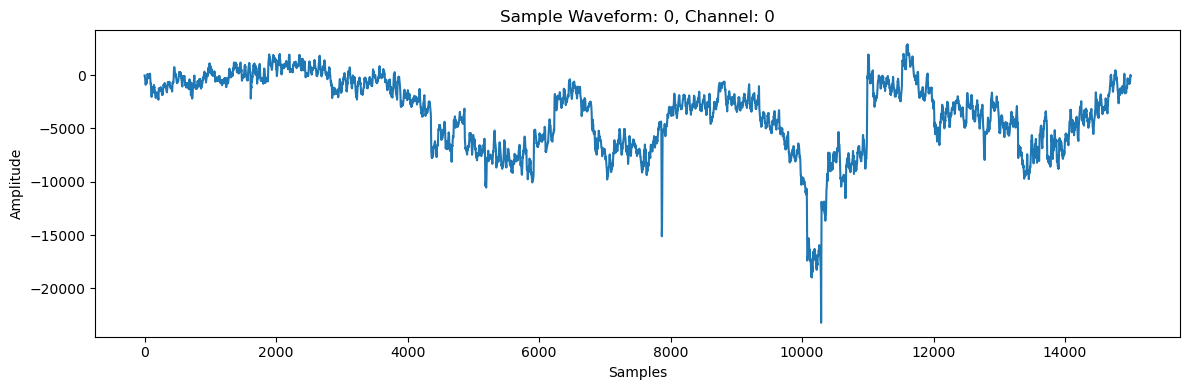

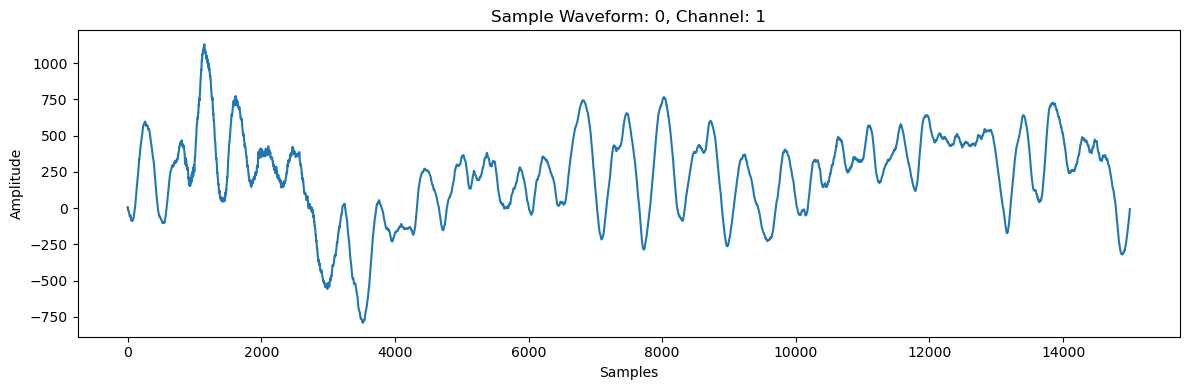

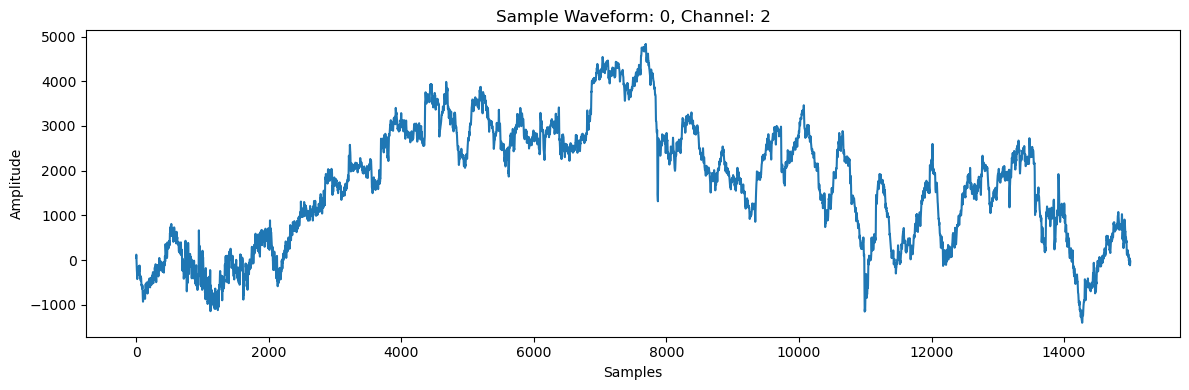

Total number of waveforms processed: 4154


In [ ]:
total_num_waveforms = 0
with h5py.File(output_waveform_file, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
                total_num_waveforms += waveform.shape[0]

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[0]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)

        for i in range(len(sample_waveform[0])):
            plt.figure(figsize=(12, 4))
            y = sample_waveform[0,i,:]
            x = np.arange(len(y))
            plt.plot(x, y)
            plt.title(f"Sample Waveform: {sample_key}, Channel: {i}")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()
        

print(f"Total number of waveforms processed: {total_num_waveforms}")
    

In [ ]:
total_num_waveforms

4154

In [158]:
save_errors = pd.read_csv(error_log_file) 
save_errors

,i_iter,network,station,starttime,endtime,stage,error
0,101,CN,WSLR,2010-01-10T04:33:10.041394Z,2010-01-10T04:35:40.041394Z,metadata_write,Unable to synchronously create group (invalid ...
1,102,UW,PASS,2010-01-10T08:54:11.319519Z,2010-01-10T08:56:41.319519Z,metadata_write,Unable to synchronously create group (invalid ...
2,103,CN,HNB,2010-01-10T08:54:11.319519Z,2010-01-10T08:56:41.319519Z,metadata_write,Unable to synchronously create group (invalid ...
3,104,CN,WSLR,2010-01-10T08:54:11.319519Z,2010-01-10T08:56:41.319519Z,metadata_write,Unable to synchronously create group (invalid ...
4,105,UW,GNW,2010-01-10T08:54:11.319519Z,2010-01-10T08:56:41.319519Z,metadata_write,Unable to synchronously create group (invalid ...
5,106,CN,HNB,2010-01-10T09:36:51.223994Z,2010-01-10T09:39:21.223994Z,metadata_write,Unable to synchronously create group (invalid ...
6,107,UW,PASS,2010-01-10T09:36:51.223994Z,2010-01-10T09:39:21.223994Z,metadata_write,Unable to synchronously create group (invalid ...
7,108,CN,WSLR,2010-01-10T09:36:51.223994Z,2010-01-10T09:39:21.223994Z,metadata_write,Unable to synchronously create group (invalid ...
8,109,UW,YACT,2010-01-10T10:32:45.424820Z,2010-01-10T10:35:15.424820Z,metadata_write,Unable to synchronously create group (invalid ...
9,110,UW,PASS,2010-01-10T10:45:03.367989Z,2010-01-10T10:47:33.367989Z,metadata_write,Unable to synchronously create group (invalid ...
